# Realistic and controlled image generation using Generative Adversarial Networks and Variational Autoencoders 

-------------------------

## Part 2 - Generating Controlled Images

----------------------------


# Introduction - Generaing Controlled Images

In this part of the project, we're going to use the pretrained VAE to generate images by finding and changing encodings that produce the desired results. This pretrained VAE was trained as the "generator side of a GAN", yielding very high quality images in most situations.    

First we will find the "mean encoding" for each number (an encoding that is capable of generating the desired number), then, we will select among the images those that have traits we like, such as bold, italic, etc.    

Using mathematical operations with these encodings, we will try to generate numbers mixing the traits to reach a desired result. 

We expect, for instance, to do things like:

- Find the encodings for each number    
- Get the encoding for a bold number 2, for instance    
- Subtract the encoding of "2" from the "bold 2" encoding   
    - The result should be a roughly pure "bold" trait that can be added to any number     
- Add the resulting "bold encoding" to other numbers    
- See the final encodings generate those other numbers in bold   

With this, we can manipulate the images and generate many types of different new images that make sense and are high quality.   



# Imports

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 
from IPython.display import Markdown, display

import tensorflow as tf
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Optimizer, Adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy, mean_squared_error
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.mnist import load_data
import tensorflow.keras.backend as K

from google.colab import drive
drive.mount('/content/drive')
wDir = "/content/drive/My Drive/BI_Master/Projeto/"

npRandom = np.random.default_rng()

Mounted at /content/drive


## Functions for plotting and checking

In [2]:
#plots 40 images in 4 rows using the passed labels as titles - needs image range 0 to 1
def plot40(images, labels, random=True):
    if random == True:
        indices = npRandom.choice(len(images), 40)
    else:
        indices = np.arange(40)

    images = images[indices].reshape((4,10) + images.shape[1:-1])
    if labels is not None:
        labels = labels[indices].reshape((4,10) + labels.shape[1:])
    plotArray(images, labels)

#takes an array of images, shape (rows, columns, img_width, img_height)
#titlesArray are the captions of the images (rows, columns)
def plotArray(imagesArray, titlesArray): 
    shp = imagesArray.shape[:2]
    
    fig, ax = plt.subplots(nrows=shp[0], ncols=shp[1], squeeze=False, figsize=(20,3*shp[0]))
    for i in range(shp[0]):
        for j in range(shp[1]):
            ax[i,j].imshow(imagesArray[i,j], vmin=0, vmax=1)
            if titlesArray is not None:
                ax[i,j].set_title(titlesArray[i,j])
            ax[i,j].set_axis_off()
            
    plt.show()



def printRange(arr, name):
    print("Range of ", name)
    print(arr.min(), "to", arr.max())

## Load data

Here we load the same MNIST dataset used in the model training phase.
Analysing this dataset is not in the scope of this project. 

In [3]:
(xTrain, yTrain), (xTest, yTest) = load_data()
print("Shapes:")
print("xTrain & yTrain", xTrain.shape, yTrain.shape)
print("xTest & yTest", xTest.shape, yTest.shape)

print("\nRanges:")
print("x:", xTrain.min(), " - ", xTrain.max(), " --- ", xTest.min(), " - ", xTest.max())
print("y:", yTrain.min(), " - ", yTrain.max(), " --- ", yTest.min(), " - ", yTest.max())

11493376/11490434 [==============================] - 0s 0us/step
Shapes:
xTrain & yTrain (60000, 28, 28) (60000,)
xTest & yTest (10000, 28, 28) (10000,)

Ranges:
x: 0  -  255  ---  0  -  255
y: 0  -  9  ---  0  -  9


In [4]:
#Normalize X
xTrain = xTrain.astype("float32") / 255.
xTest = xTest.astype("float32") / 255.

#Adding channels
xTrain = xTrain.reshape(-1, 28,28, 1)
xTest = xTest.reshape(-1, 28,28, 1)

#See ranges
print("Max x:", xTrain.max(), xTest.max())

#Plotting  samples
# print("Train images")
# plot40(xTrain, yTrain)
# print("\n\n\nTest images")
# plot40(xTest, yTest)

Max x: 1.0 1.0


## Load pretrained models

Loading pretrained models for the Variational Autoencoder

In [5]:
encoder = load_model(wDir+"best2_encoder")
decoder = load_model(wDir+"best2_decoder")

# Generating the mean numbers

Here, we separate all images for each number, encode all the images using the "encoder" model and take the mean of the encodings for each number. We store the `numberEncodings` for later use.



In [6]:
#separating 10 groups of images, 1 for each label
numberImages = [xTrain[yTrain==n] for n in range(10)]
lengths = [len(imgs) for imgs in numberImages]

#counting the number o batches for each group
batchSize = 1000
batchCounts = []
for l in lengths:
    bCount = l // batchSize
    if l % batchSize > 0:
        bCount += 1
    batchCounts.append(bCount)

#generating encoded data for each group
allNumberEncodings = [[] for _ in range(10)]
for imgs,enc,bCount in zip(numberImages, allNumberEncodings, batchCounts):
    for b in range(bCount):
        means, _ = encoder(imgs[b*batchSize : (b+1)*batchSize], training=False)
        enc.append(means.numpy())

#joining batches
allNumberEncodings = np.array([np.concatenate(encs, axis=0) for encs in allNumberEncodings])

#taking the mean encoding for each group
numberEncodings = [np.mean(encs, axis=0) for encs in allNumberEncodings]
numberEncodings = np.array(numberEncodings)

print("Shape of 'numberEncodings': ", numberEncodings.shape)

Shape of 'numberEncodings':  (10, 15)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Visualizing the mean numbers

For each of the encodings generated, we use the "decoder" model to see their resulting images. 

These images are the "mean numbers", that should be the ideal written number according to the dataset variations.    

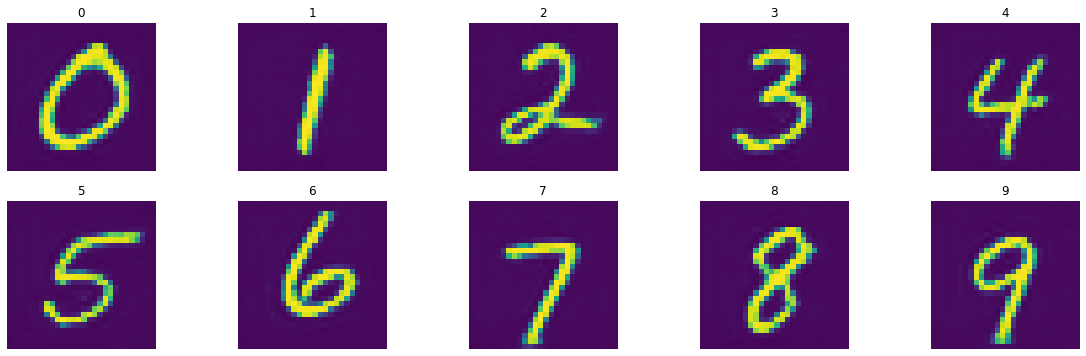

In [7]:
#generating the images from the mean encodings
generated = decoder(numberEncodings, training=False)
generated = generated.numpy().reshape((2,5) + generated.shape[1:-1])
labels = np.arange(10).reshape((2,5))

plotArray(generated, labels)

nums, encSize = numberEncodings.shape

# Analysing the number encodings

## The "central" number

Here we get the mean of all number encodings, also the median, and generate their respective images.
This is roughly the number that is the center among all other numbers.   

Although it's visibly not any of the numbers, we can still see a high quality image (good sharpness, almost zero noise) that may resemble a few numbers, such as 9 and 3.   

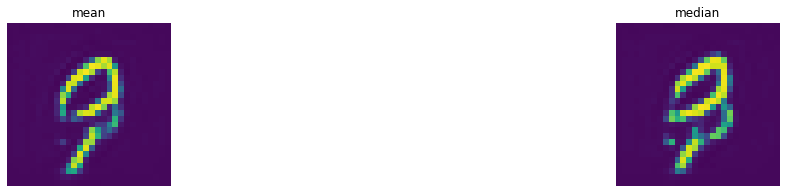

In [8]:
centralEncoding = np.mean(numberEncodings, axis=0)
medianEncoding = np.median(numberEncodings, axis=0)
centralEncodings = np.stack([centralEncoding, medianEncoding], axis=0)
images = decoder.predict(centralEncodings).reshape(1,2,28,28)
labels = np.array([["mean", "median"]])

plotArray(images, labels)


## Distances between numbers

Here we compare how far (in terms of mathematical Euclidian distance between two encodings) the numbers are from each other.   

We see some expected results, like:
- 1 is very distant from 0 in terms of shape.       
- 9 is near 7 and 4 (their images are very similar).   
- 9 is also the closest to the mean/median encoding, as we commented in the picuture above.   

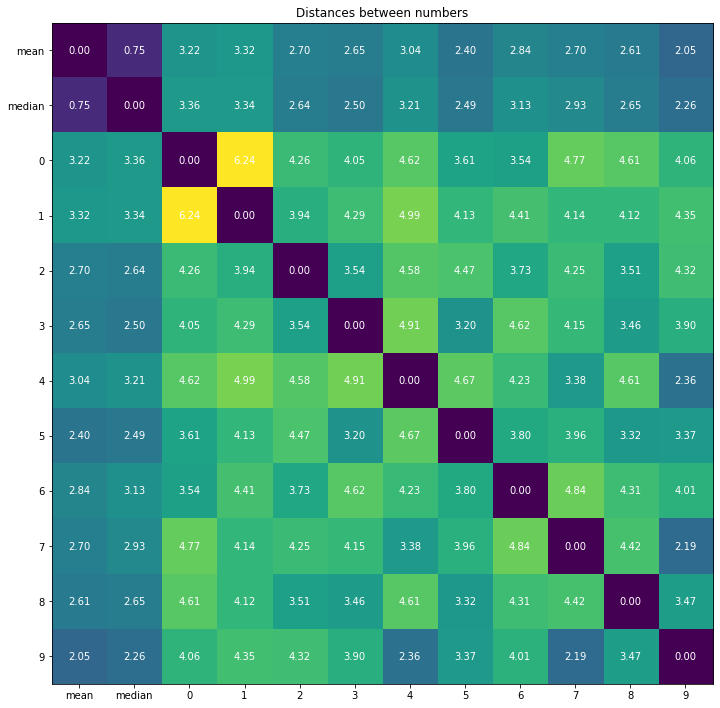

In [9]:
def distance(arr1, arr2):
    return np.sqrt(
        np.sum(
            np.square(arr1 - arr2), axis=-1
        )
    )

def distancePlot(rowEncodings, columnEncodings, rowLabels, columnLabels):
    inRows = rowEncodings.reshape((-1, 1, encSize))
    inColumns = columnEncodings.reshape((1,-1,encSize))

    dist = distance(inRows, inColumns)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(dist)

    rngX = range(len(columnLabels))
    rngY = range(len(rowLabels))
    # We want to show all ticks...
    ax.set_xticks(rngX)
    ax.set_yticks(rngY)
    # ... and label them with the respective list entries
    ax.set_xticklabels(columnLabels)
    ax.set_yticklabels(rowLabels)

    # Loop over data dimensions and create text annotations.
    for i in rngY:
        for j in rngX:
            text = ax.text(j, i, "{:.2f}".format(dist[i, j]),
                        ha="center", va="center", color="w")

    ax.set_title("Distances between numbers")
    fig.tight_layout()
    plt.show()

allAndCentral = np.concatenate([centralEncodings, numberEncodings], axis=0)
allAndCentralLabels = ["mean", "median"] + list(range(10))

distancePlot(allAndCentral, allAndCentral, allAndCentralLabels, allAndCentralLabels)



## Transitions between numbers

Here we try to make a smooth path from one number to another by linearly combining percentages of the number encodings.   

The labels above each image are the "nearest" (euclidian) encoding, sometimes going straight from one number to another crosses the space of a different number. (But the size of the space occupied by each number varies, and this size is not taken into account here)

We can see some very smooth transitions for some numbers, while for others, the transition passes through weird shapes.    

Some very interesting transitions that work exactly as we would expect are:   

- From 1 to 7    
- From 3 to 8    
- From 4 to 9
- From 5 to 6    

It's also interesting to see the transitions from 4 to 7 and from 4 to 8 passing through 9 first, following a logical path.   

This smooth passage is a result of the VAE.    
And even though some have weird shapes, the image is still well behaved, without noise and with good sharpness. This is a result of the GAN.     

In [10]:
encs = []
labs = []
steps = 20
for i in range(10):
    for j in range(i,10):
        if i == j:
            continue 
        for s in range(steps+1):
            enc = (s*numberEncodings[j] + (steps-s-1)*numberEncodings[i])/steps   #(encodedSize,)
            encs.append(enc)

            if s == 0:
                labs.append(str(i))
            elif s == steps:
                labs.append(str(j))
            else:
                dist = distance(enc, numberEncodings)
                labs.append(np.argmin(dist))

encs = np.array(encs)
labs = np.array(labs).reshape((-1,steps+1))
outs = decoder.predict(encs).reshape((-1,steps+1,28,28))
plotArray(outs, labs)

Output hidden; open in https://colab.research.google.com to view.

# Selecting numbers with certain traits from the dataset

Here, we manually select numbers based on some traits we can observe. 

We're selecting samples for numbers that have these traits:  
- Bold (thick) numbers   
- Italic numbers   
- Wide curvy numbers (very round corners)   
- Edgy numbers (sharp corners)
- Thin (opposite to bold) numbers    

We have a selection that takes samples from all numbers, but we also have a more radical selection that samples only from the numbers that most evidently show the target trait.    

In [11]:
#plot the first many images for each number, just to look
def plotManyNumbers():
    for i in range(10):
        plotMany(i)

def plotMany(number=None):
    if number is None:
        plotManyNumbers()
    else:
        plot40(numberImages[number][:40], np.arange(40), random=False)
        plot40(numberImages[number][40:80], np.arange(40,80), random=False)
        plot40(numberImages[number][80:120], np.arange(80,120), random=False)

#plotMany() #this line is only called to see the numbers
    


## Selected numbers


In [12]:
#indices relative to the numberImages previously defined

thickNumbers = [
    [4, 31, 32, 38, 39,46,50,62],
    [18,21,29,30,34,54,74],
    [2,16,20,39,5,60,76,78],
    [3,12,33,16,26],
    [5,18,22,30,2],
    [16,25,53,37,62],
    [3,5,17,21,27,77],
    [17,20,44,77,73],
    [1,19,25,41,43,63,79],
    [41,47,56,77,78]
]
italicNumbers = [
    [44,48,50,55,58,60,65,73,74,76],
    [4,27,28,50,64,62,69,70,77,78],
    [31,36,39,22,29],
    [17,21,29,42,51,56,58,76,78,68],
    [1,7,12,13,46,51,59,62,64,65,78],
    [61,77,68,46,58,35,27],
    [90,93,85],
    [5,6,47,50,73,76,71,59],
    [14,16,24,29,31,55,58,47,77],
    [14,22,44,54,55,64,62,63,66,69]
]

curvyNumbers = [
    [7, 21, 28, 45, 102],
    [],
    [37, 49],
    [40, 92],
    [22,43,60,81,93],
    [106],
    [1, 5, 20, 38, 70, 83, 91, 109, 112],
    [48, 60],
    [13, 26, 102, 108],
    [9, 37, 95]
]

edgyNumbers = [
    [],
    [36, 60, 92],
    [10],
    [102],
    [12,57,58,99],
    [91],
    [85, 103],
    [53, 57, 103, 110],
    [116],
    [29,31]
]
thinNumbers = [
    [30,23,7,98,114],
    [19,36,79,109,119],
    [71,102,109],
    [109,52],
    [10,45,58,68,79,62,114],
    [24,29,70,102],
    [1,34,70,85,109],
    [48,60],
    [10,32,52,61],
    [92,2]
]


thickestNumbers = [
    [115,116],
    [45,54,108],
    [],[],[],[],[],[],[],[]
]
mostItalicNumbers = [
    [101,98],
    [117,99,82,77,69,70,64],
    [],
    [],
    [12,52,59,62,78,117],
    [],
    [],
    [51],
    [32,83,87],
    [55,54,57,62]
]

mostCurvyNumbers = [
    [21,28],
    [],
    [37],
    [],
    [22,60],
    [],
    [1,109],
    [48],
    [],
    [9, 37]
]

mostEdgyNumbers = [
    [],[],
    [19,30],
    [94],
    [1,7,12,57],
    [102],
    [],
    [14, 16, 43, 103, 117],
    [],
    []
]

thinnestNumbers = [
    [114],
    [36,79],
    [102],
    [],
    [68,79],
    [70],
    [70],
    [],
    [32,61],
    []  
]


## Visualizing some of the selected numbers

### Thick numbers (bold)

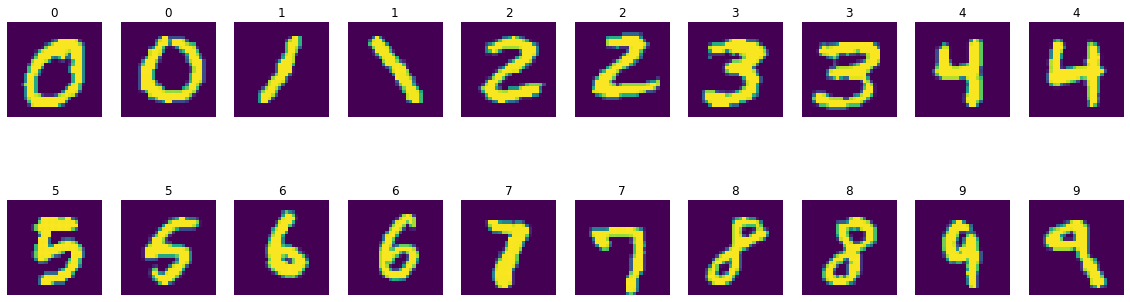

### Italic numbers

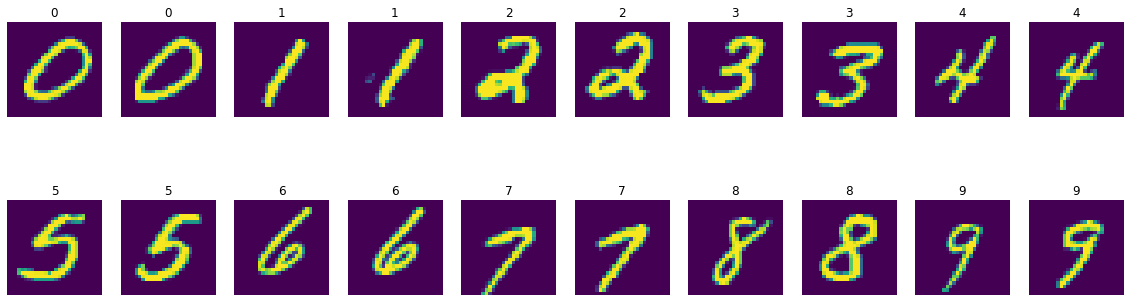

### Wide curvy numbers

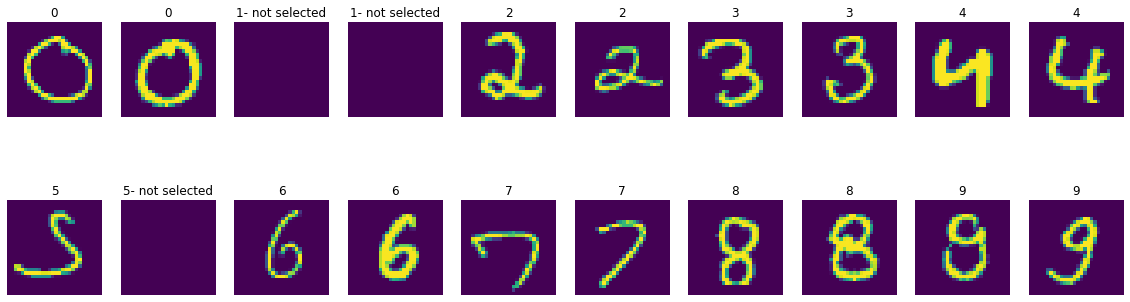

### Edgy numbers

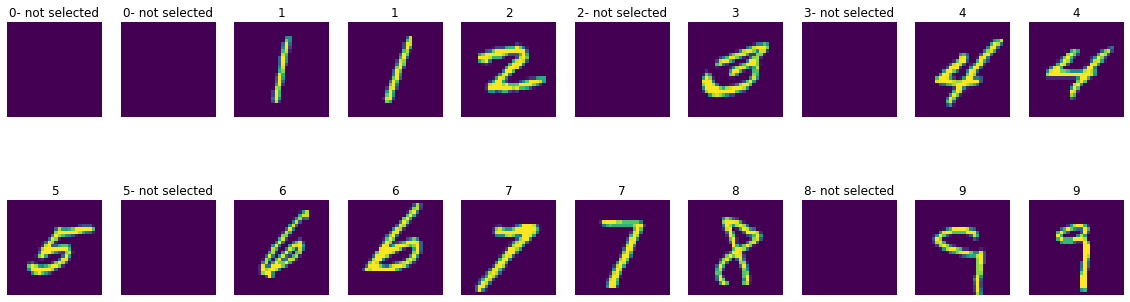

### Thin numbers

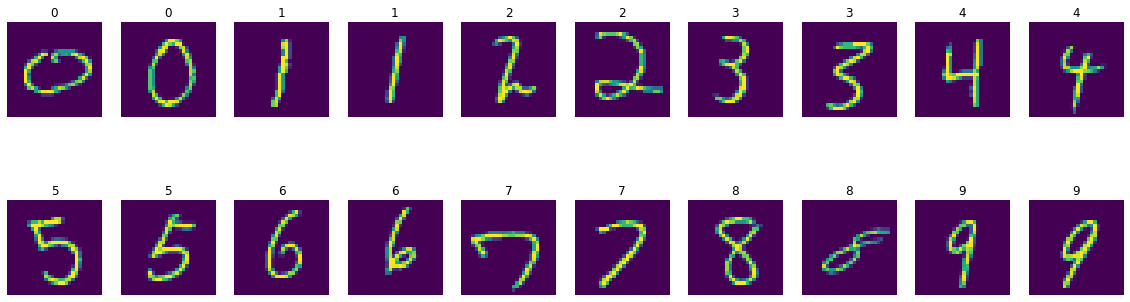

In [13]:
def getFirstFromList(theList, howMany):
    result = []
    legends = []
    for n, subList in enumerate(theList):
        subResult = []
        subLegends = []
        result.append(subResult)
        legends.append(subLegends)

        for i in range(howMany):
            if i < len(subList):
                subResult.append(numberImages[n][subList[i]])
                subLegends.append(str(n))
            else:
                subResult.append([[[0]]*28]*28) #empty image
                subLegends.append(str(n) + "- not selected")
    return np.array(result).reshape(howMany, 10, 28, 28), np.array(legends).reshape(howMany, 10)
    # return np.array([[numberImages[n][subList[i]] for i in range(howMany)] for n, subList in enumerate(theList)])

titles = ["### Thick numbers (bold)", "### Italic numbers", "### Wide curvy numbers", "### Edgy numbers", "### Thin numbers"]
selectedLists = [thickNumbers, italicNumbers, curvyNumbers, edgyNumbers, thinNumbers]
amounts = [2,2,2,2,2]

for title, lst, amount in zip(titles, selectedLists, amounts):
    display(Markdown(title))
    selection, legends = getFirstFromList(lst, amount)#.reshape((amount, 10, 28, 28))
    #legends = np.array([[i for _ in range(amount)] for i in range(10)]).reshape(amount, 10)
    plotArray(selection, legends)
    print("\n\n")


# Extracting the traits and applying them to the mean numbers

Here, we take a mean of the encodings of the selected numbers above and subtract the "mean number encoding" from them. This should leave us with roughly "pure trait encodings".    

We test adding these trait encodings to all numbers to see if it's possible to transfer the traits from the selected numbers to any other number.   

The result is good for some traits, and not so good for others.   
It's possible to transfer traits from one number to another, as the selections with missing numbers also bring good results.   

### Mean numbers + traits extracted from selections with many numbers 

(6, 10, 28, 28) (6, 10)


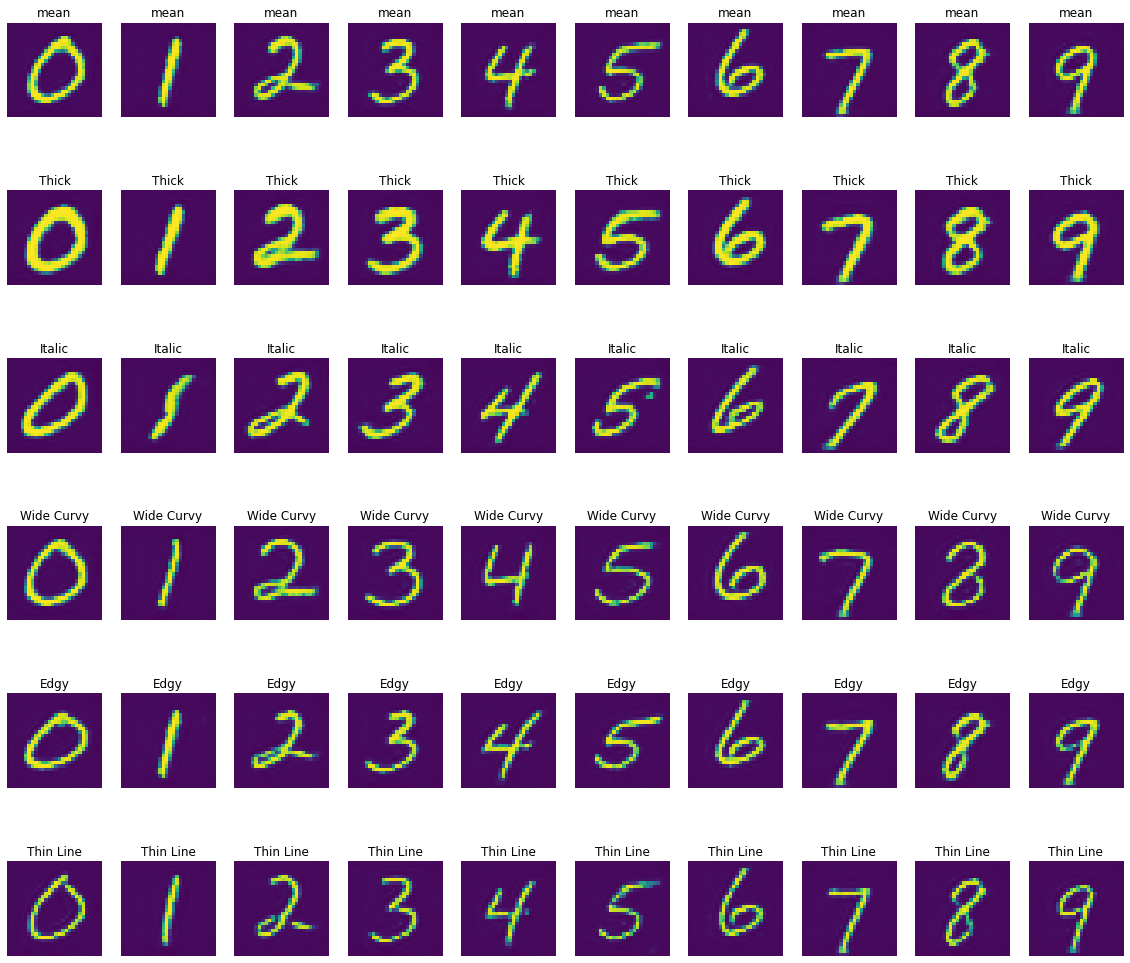



-----------------




### Mean numbers + traits extracted from selections with few most evident numbers

(6, 10, 28, 28) (6, 10)


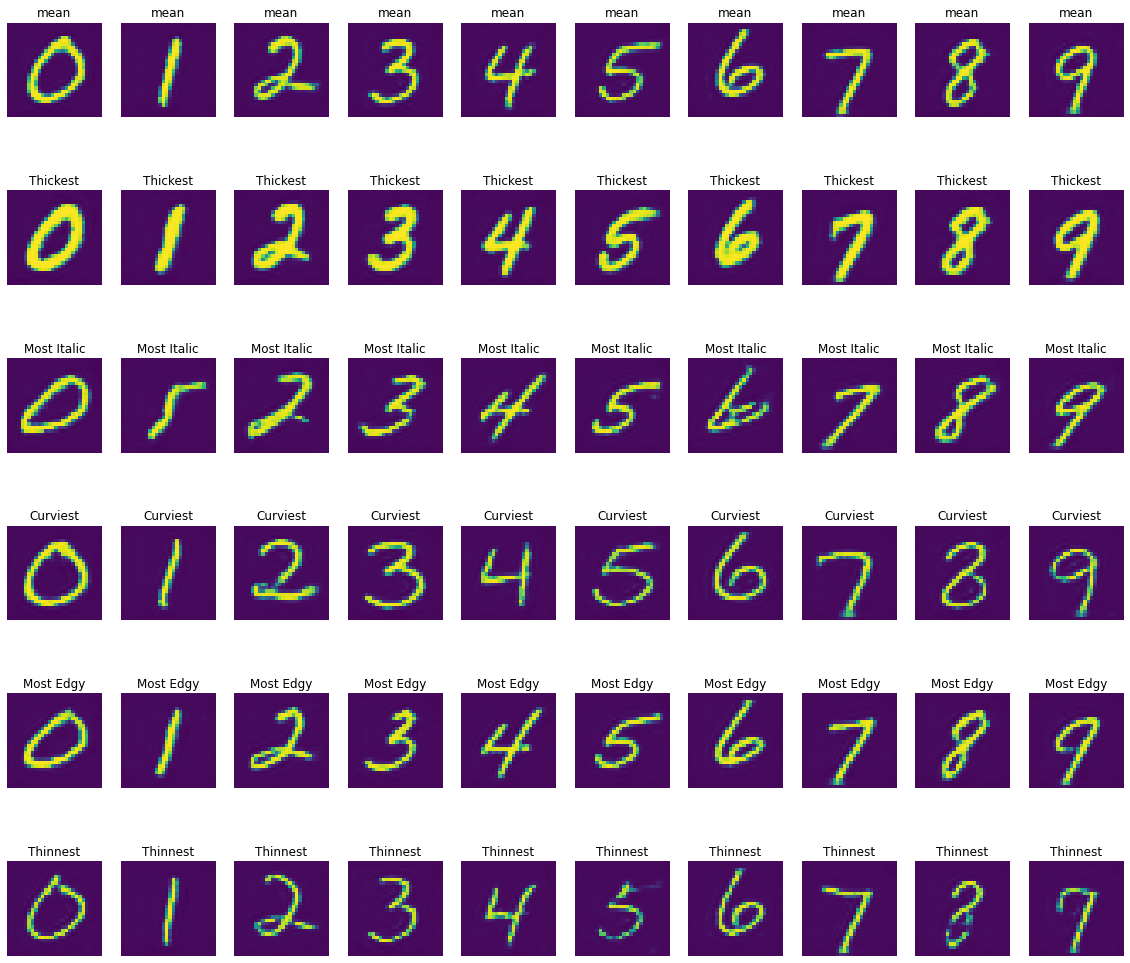

In [14]:
traitNames = ["Thick", "Italic", "Wide Curvy", "Edgy", "Thin Line"]
mostTraitNames = ["Thickest", "Most Italic", "Curviest", "Most Edgy", "Thinnest"]

def plotWithTraits(traitNames, *selectedNumbers): #selected numbers is 3D (traitNames, 10, freeListOfIndices)
    images = []
    labels = []
    finalEncodings = []

    traitCount = len(traitNames)
    columns = traitCount + 1

    subImages = []
    for enc in numberEncodings:
        enc = enc.reshape((1,-1)) #(1, encodedSize)
        subImages.append(decoder.predict(enc)[0])
    images.append(subImages)
    labels.append(["mean"]*10)


    for traitName, selected in zip(traitNames, selectedNumbers):
        subImages = []
        encodings = []

        for nEnc, numbers, imgs in zip(numberEncodings, selected, numberImages): #10 elements, 1 for each numbner
            if len(numbers) > 0:
                imgs = imgs[numbers] #select images using the indices of the selected numbers
                encs = encoder.predict(imgs)[0] - nEnc.reshape(1, -1) #(?, encodedSize) encodings for the selected numbers minus their "mean number" encoding
                encs = np.mean(encs, axis=0) #(encodedSize,)
                encodings.append(encs)    

        encodings = np.array(encodings) #(<=10,encodedSize)
        encodings = np.mean(encodings, axis=0) #(encodedSize,)
        finalEncodings.append(encodings)

        for i in range(10):
            nEnc = numberEncodings[i] #(encodedSize,)
            changedNumber = decoder.predict((nEnc + encodings).reshape(1,-1))[0]
            subImages.append(changedNumber)
        images.append(subImages)
        labels.append([traitName]*10)
    
    images = np.array(images).squeeze(axis=-1)
    labels = np.array(labels)
    print(images.shape, labels.shape)
    plotArray(images, labels)

    return finalEncodings

display(Markdown("### Mean numbers + traits extracted from selections with many numbers "))
thickEnc, italicEnc, curvyEnc, edgyEnc, thinEnc = plotWithTraits(traitNames, thickNumbers, italicNumbers, curvyNumbers, edgyNumbers, thinNumbers)
print("\n\n-----------------\n\n")

display(Markdown("### Mean numbers + traits extracted from selections with few most evident numbers"))
thickestEnc, mostItalicEnc, mostCurvyEnc, mostEdgyEnc, thinnestEnc = plotWithTraits(
    mostTraitNames, thickestNumbers, mostItalicNumbers, mostCurvyNumbers, mostEdgyNumbers, thinnestNumbers)


traits = [thickEnc, italicEnc, curvyEnc, edgyEnc, thinEnc]
mostTraits = [thickestEnc, mostItalicEnc, mostCurvyEnc, mostEdgyEnc, thinnestEnc]

## Slowly subtracting / adding the traits to the numbers

Since in the previous results we saw that some traits can cause a big distortion or even change a number to another (which is not desired), we will try to add the traits gradually.   

Instead of adding the trait encodings to the mean number encodings entirely, we will gradually add fractions of the trait encodings.

Very interesting effect: although there is a lot of distortion and sometimes one number changes into another, it's possible to see transitions in the effects, and even the expected negative effect makes sense for most of the traits.   

We can see "negative bold" producing "thin numbers".    
We can see the line thickness slowly increasing, very upright numbers transitioning to very italic numbers, narrow numbers transitioning to wide numbers, etc. 

### Thick numbers progression

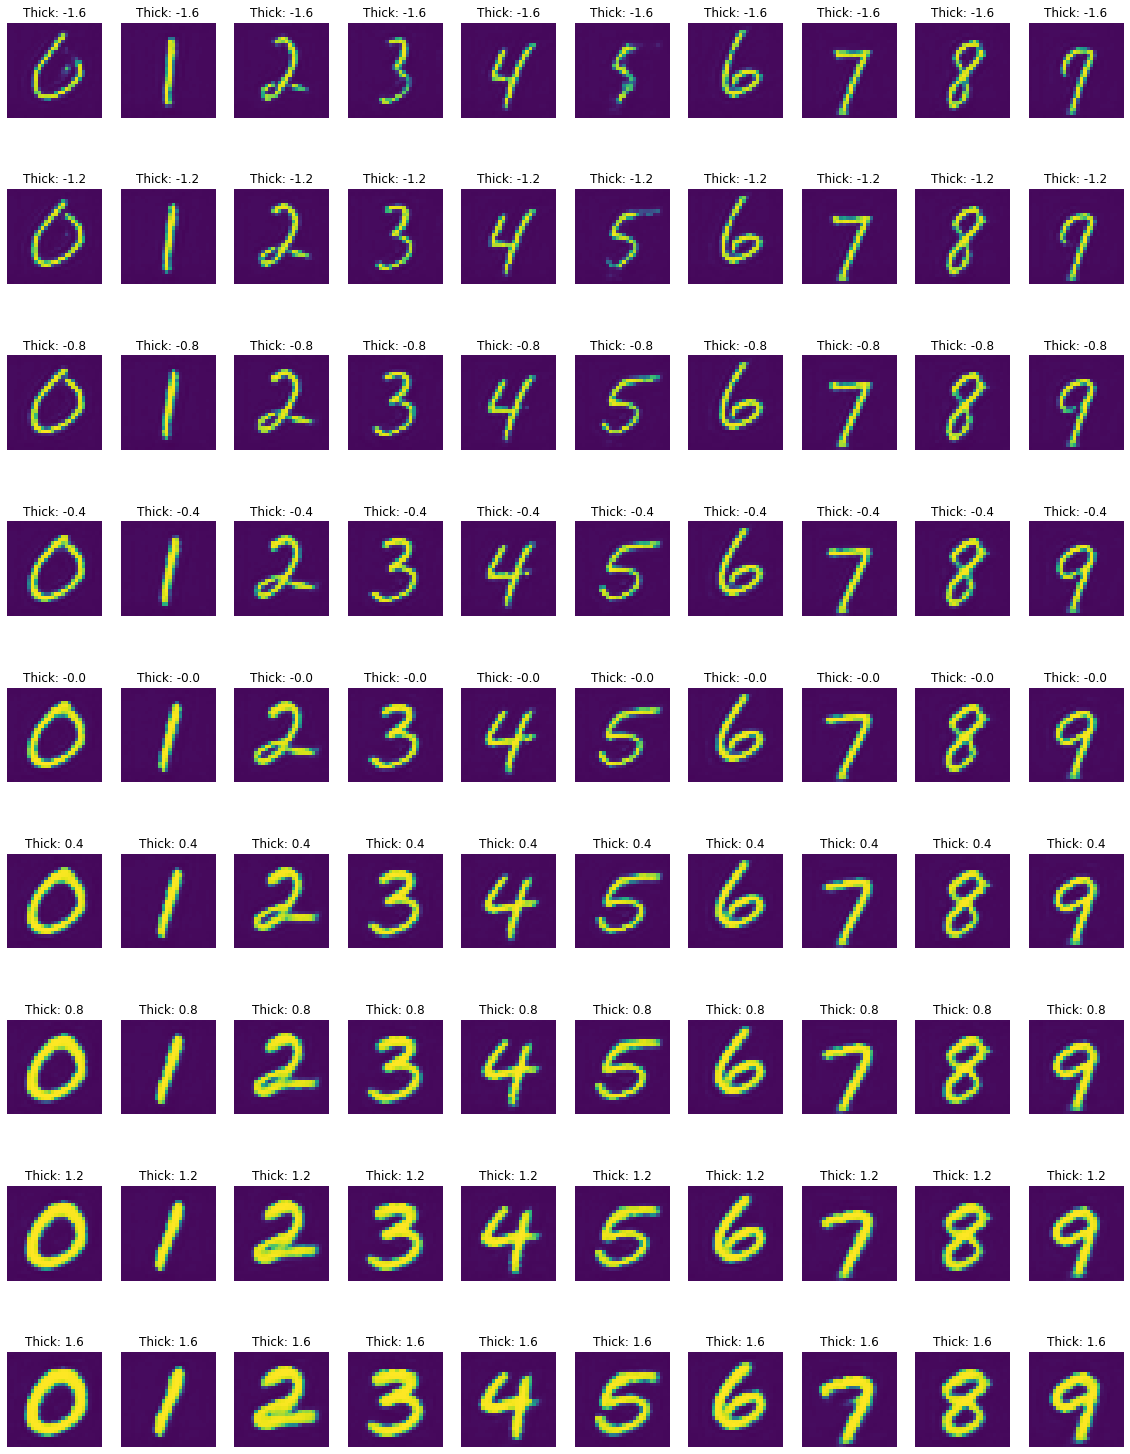

### Italic numbers progression

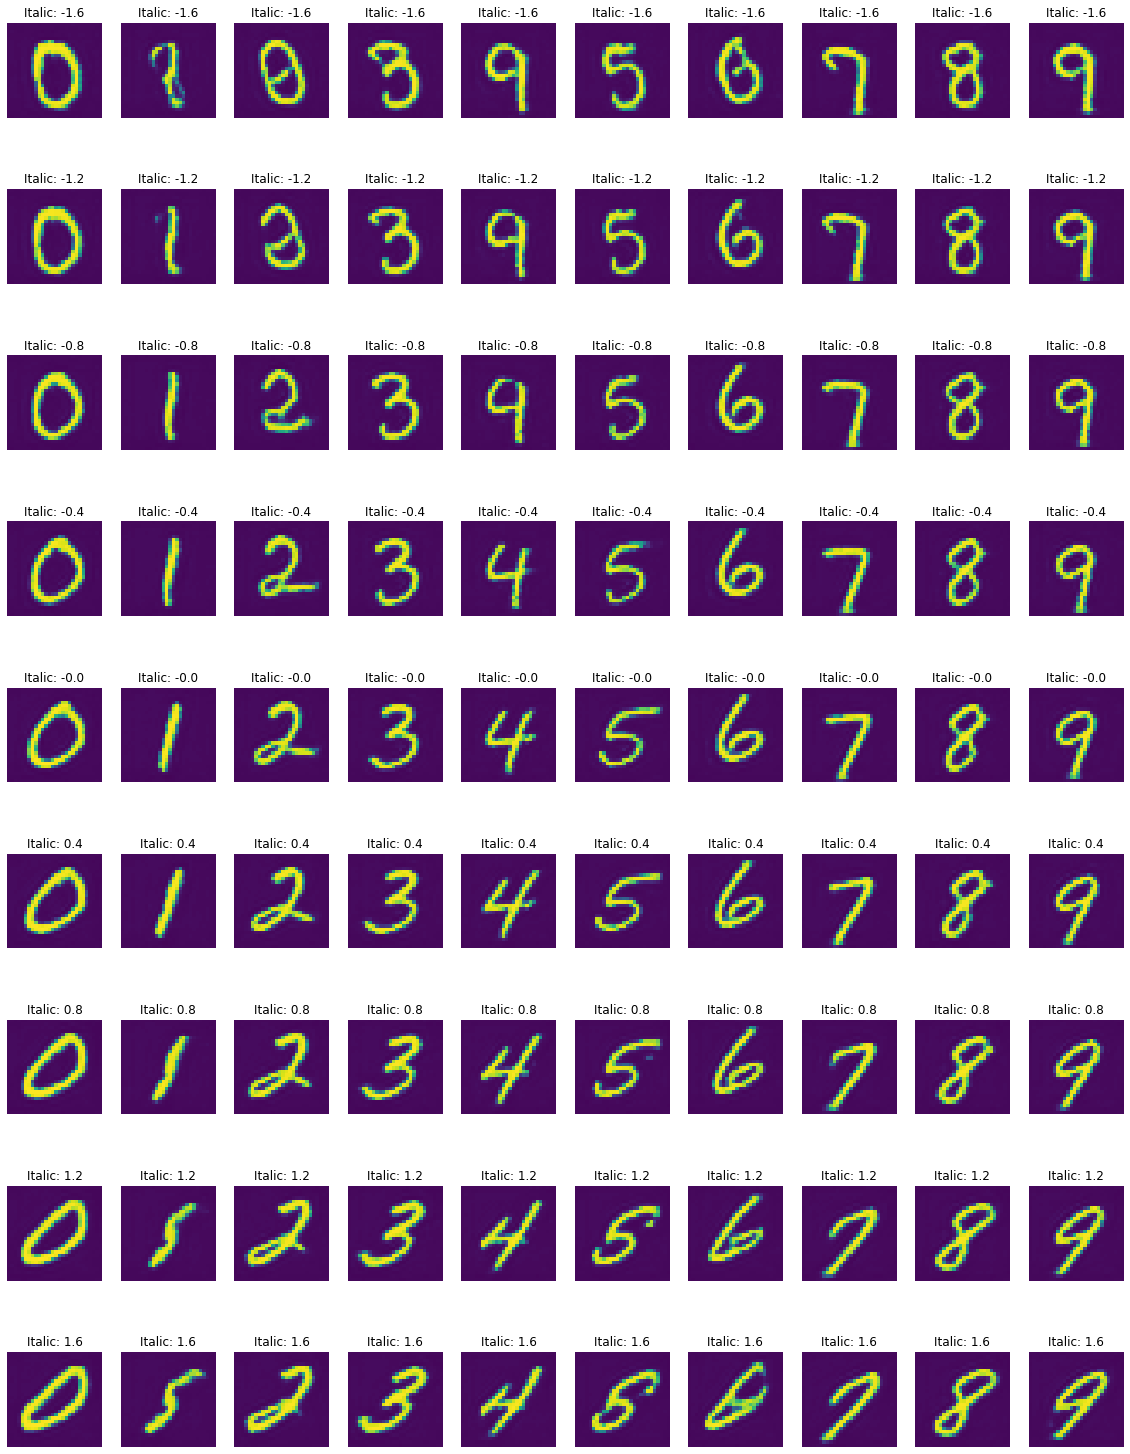

### Wide Curvy numbers progression

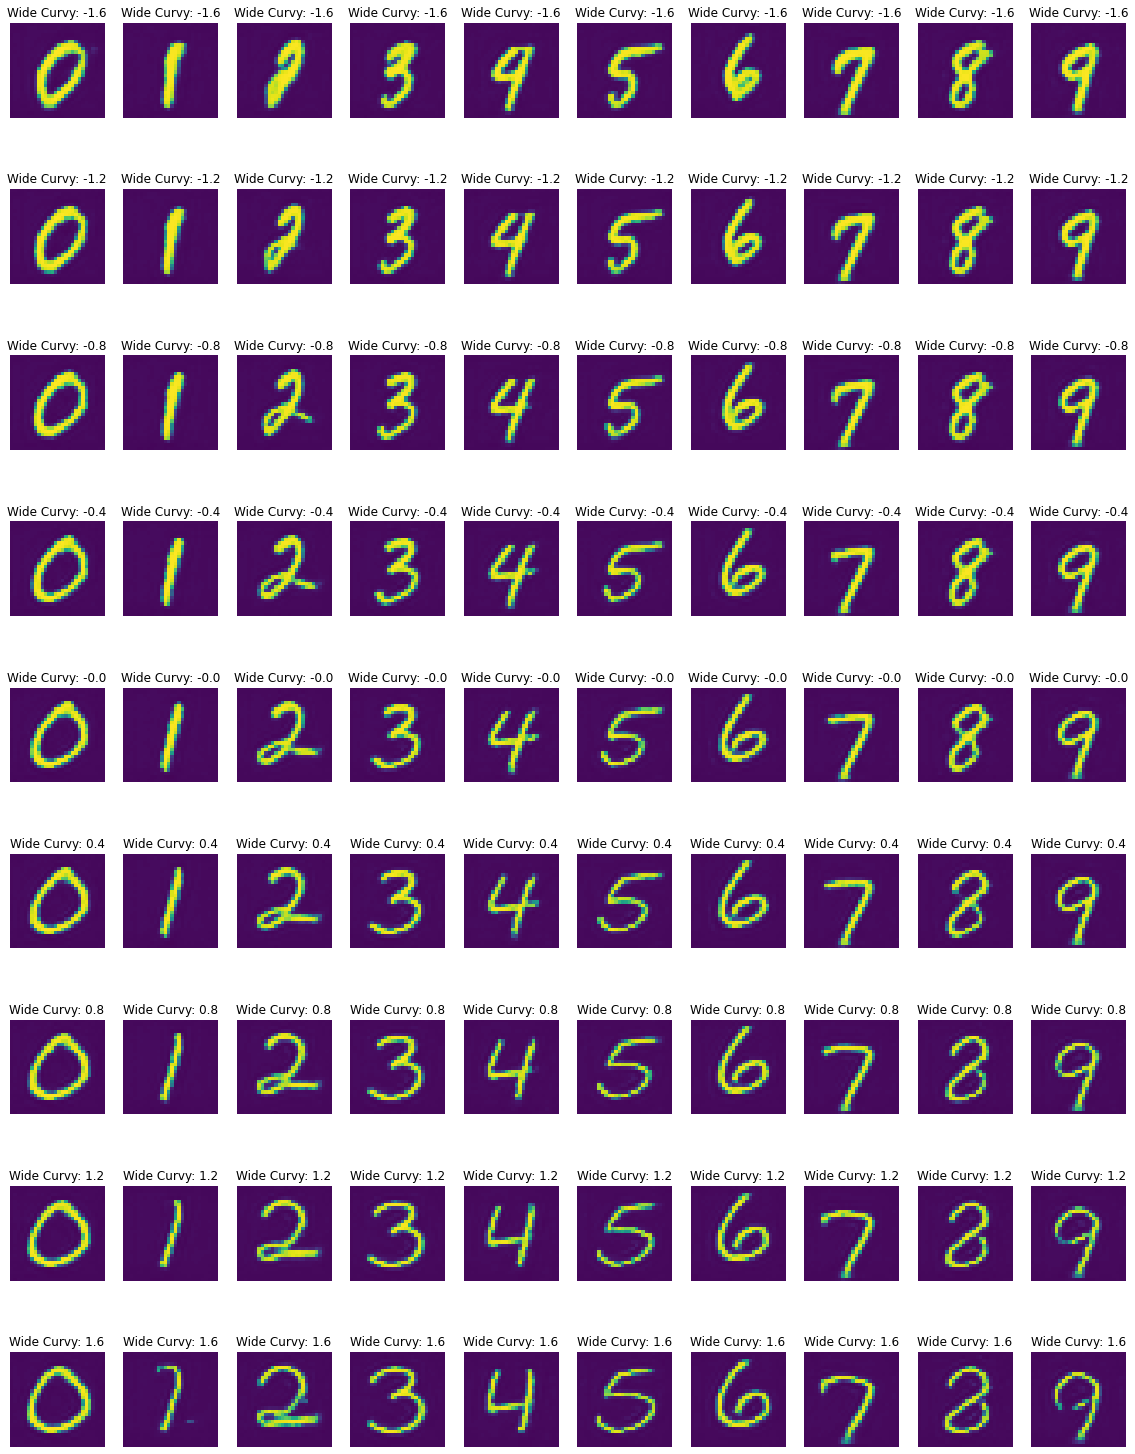

### Edgy numbers progression

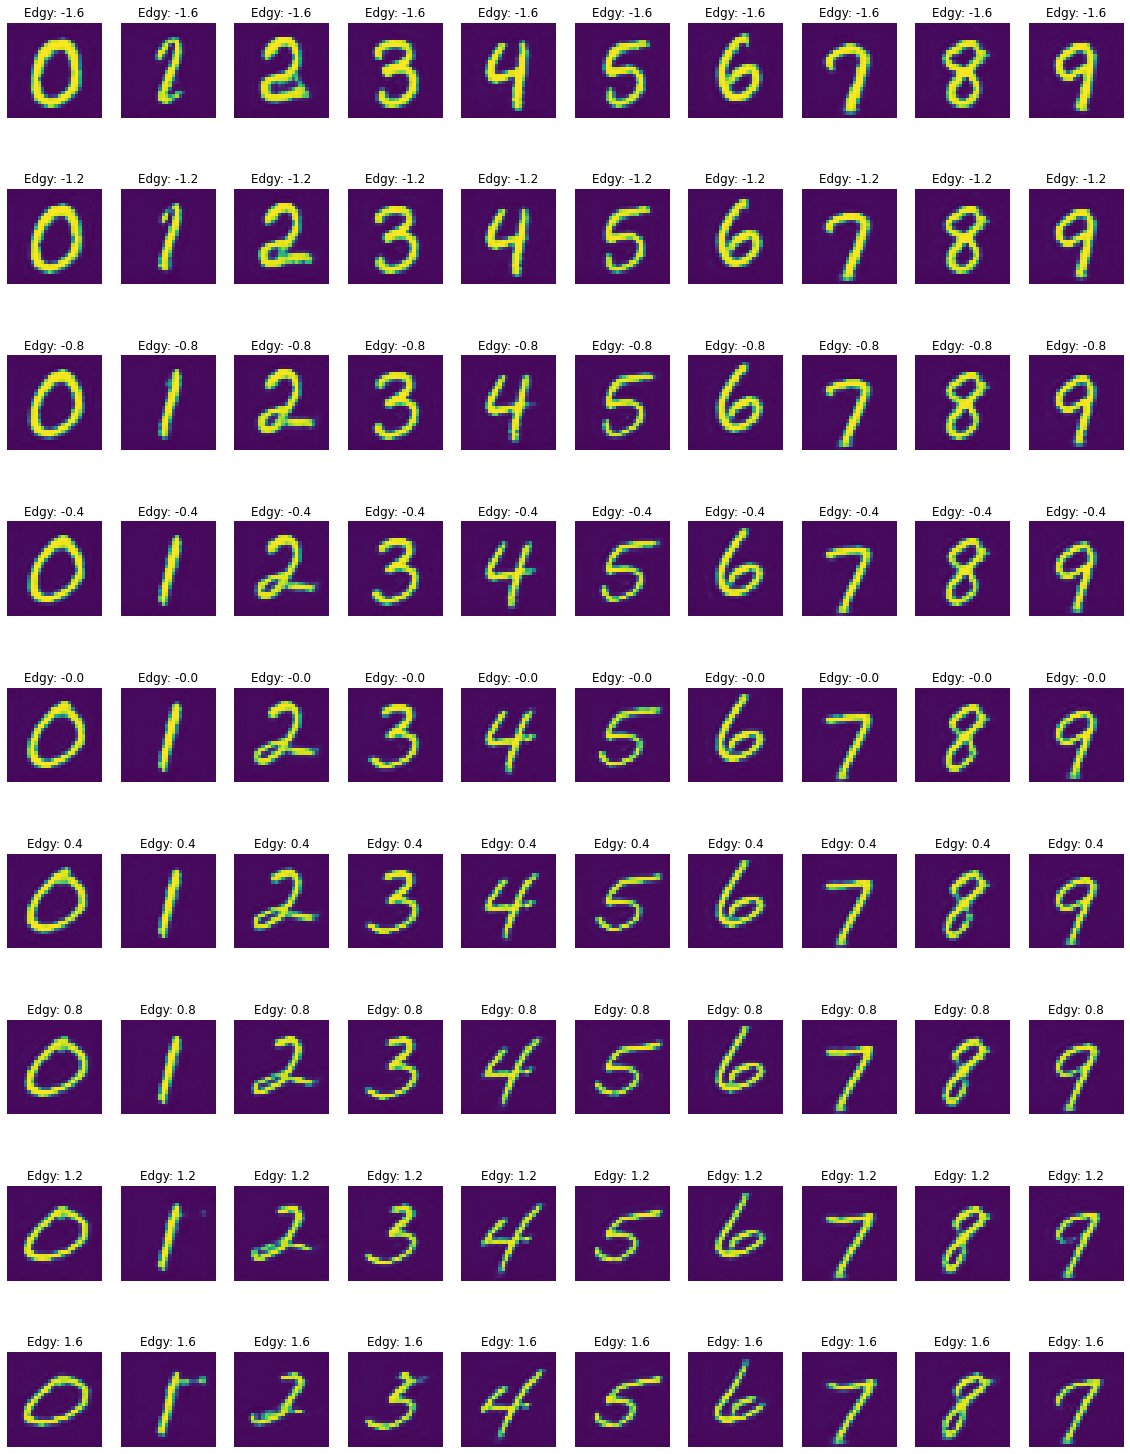

### Thin Line numbers progression

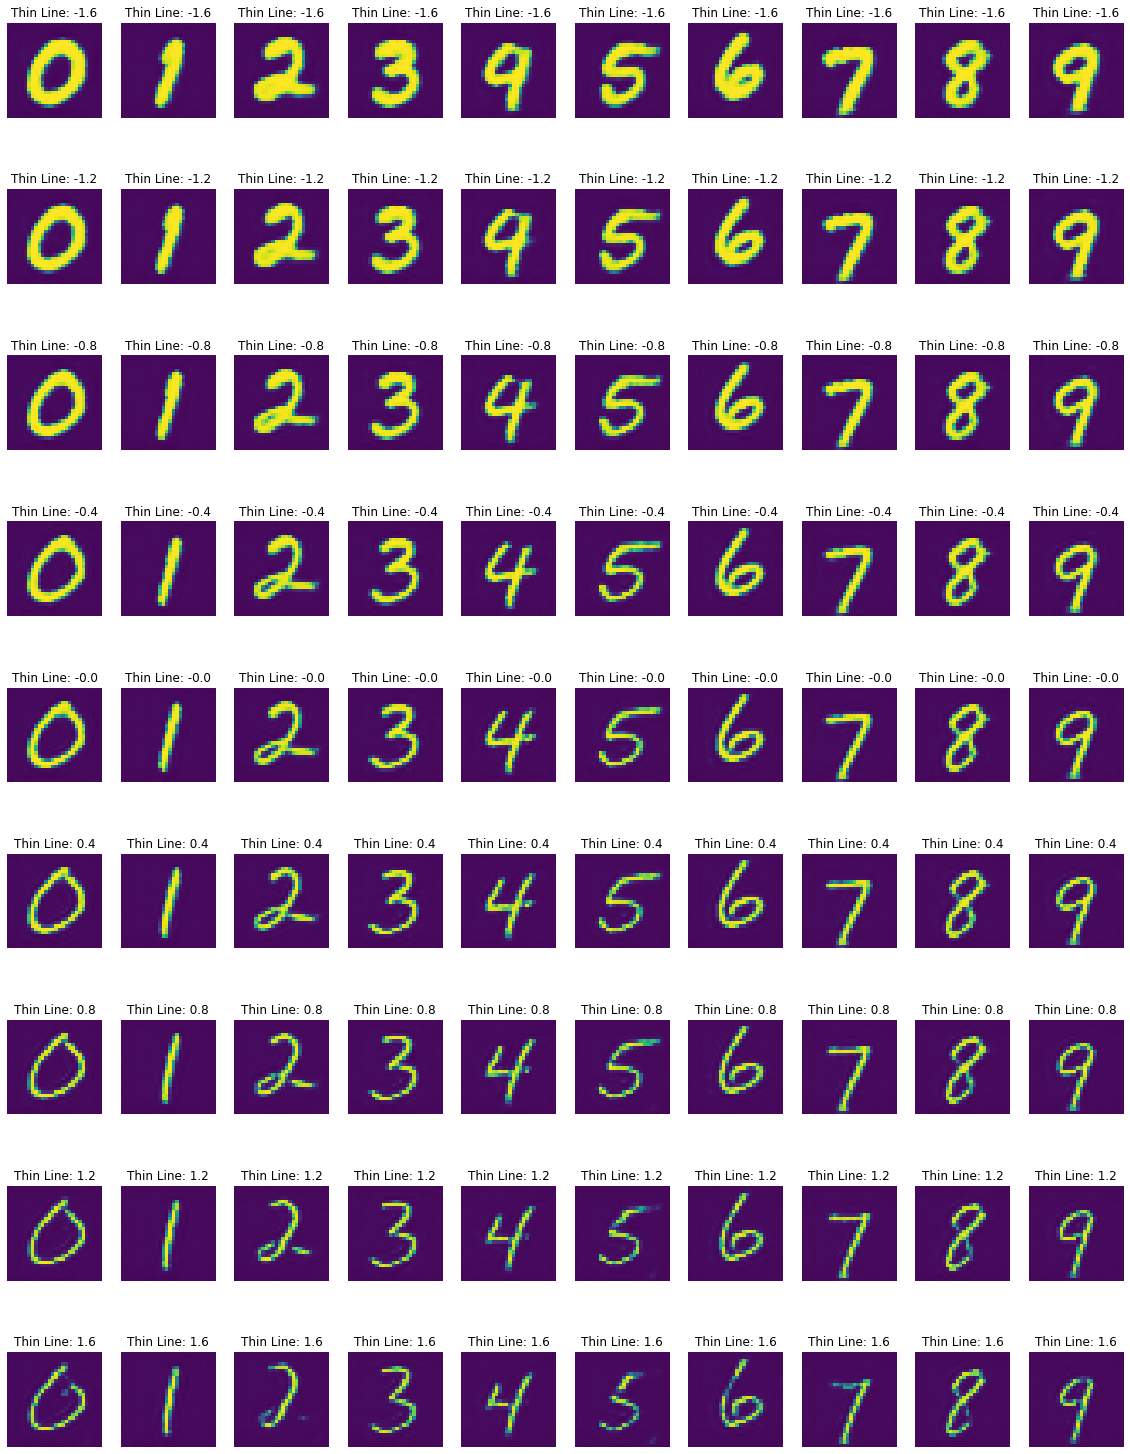

### Thickest numbers progression

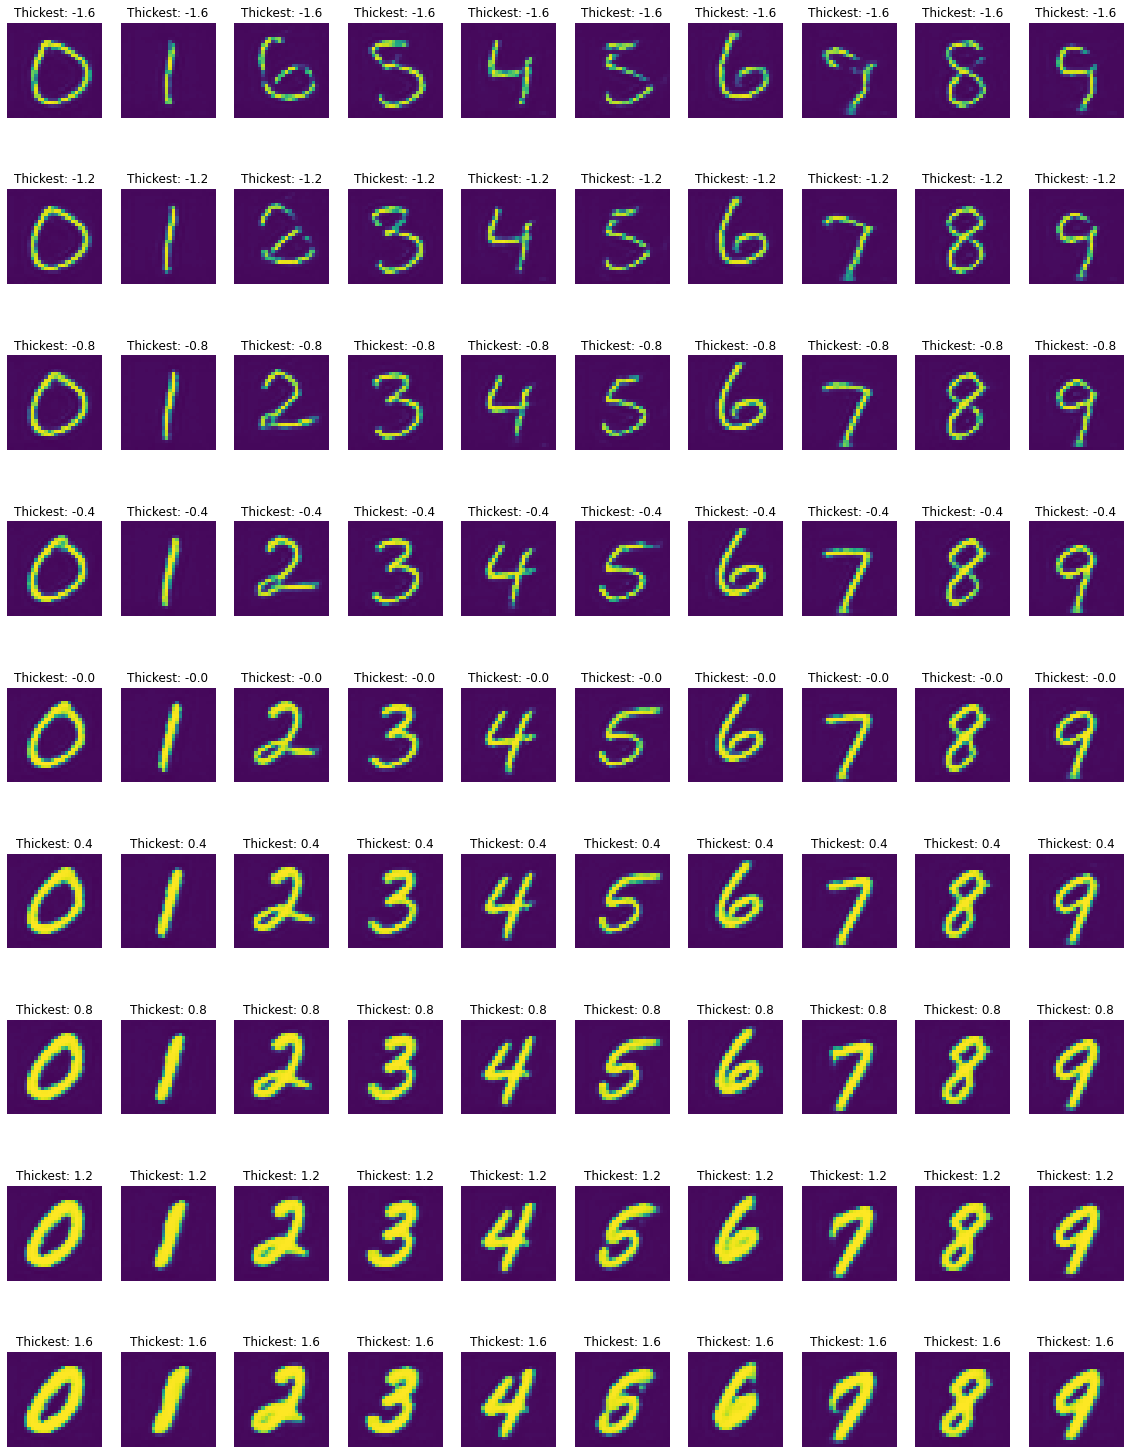

### Most Italic numbers progression

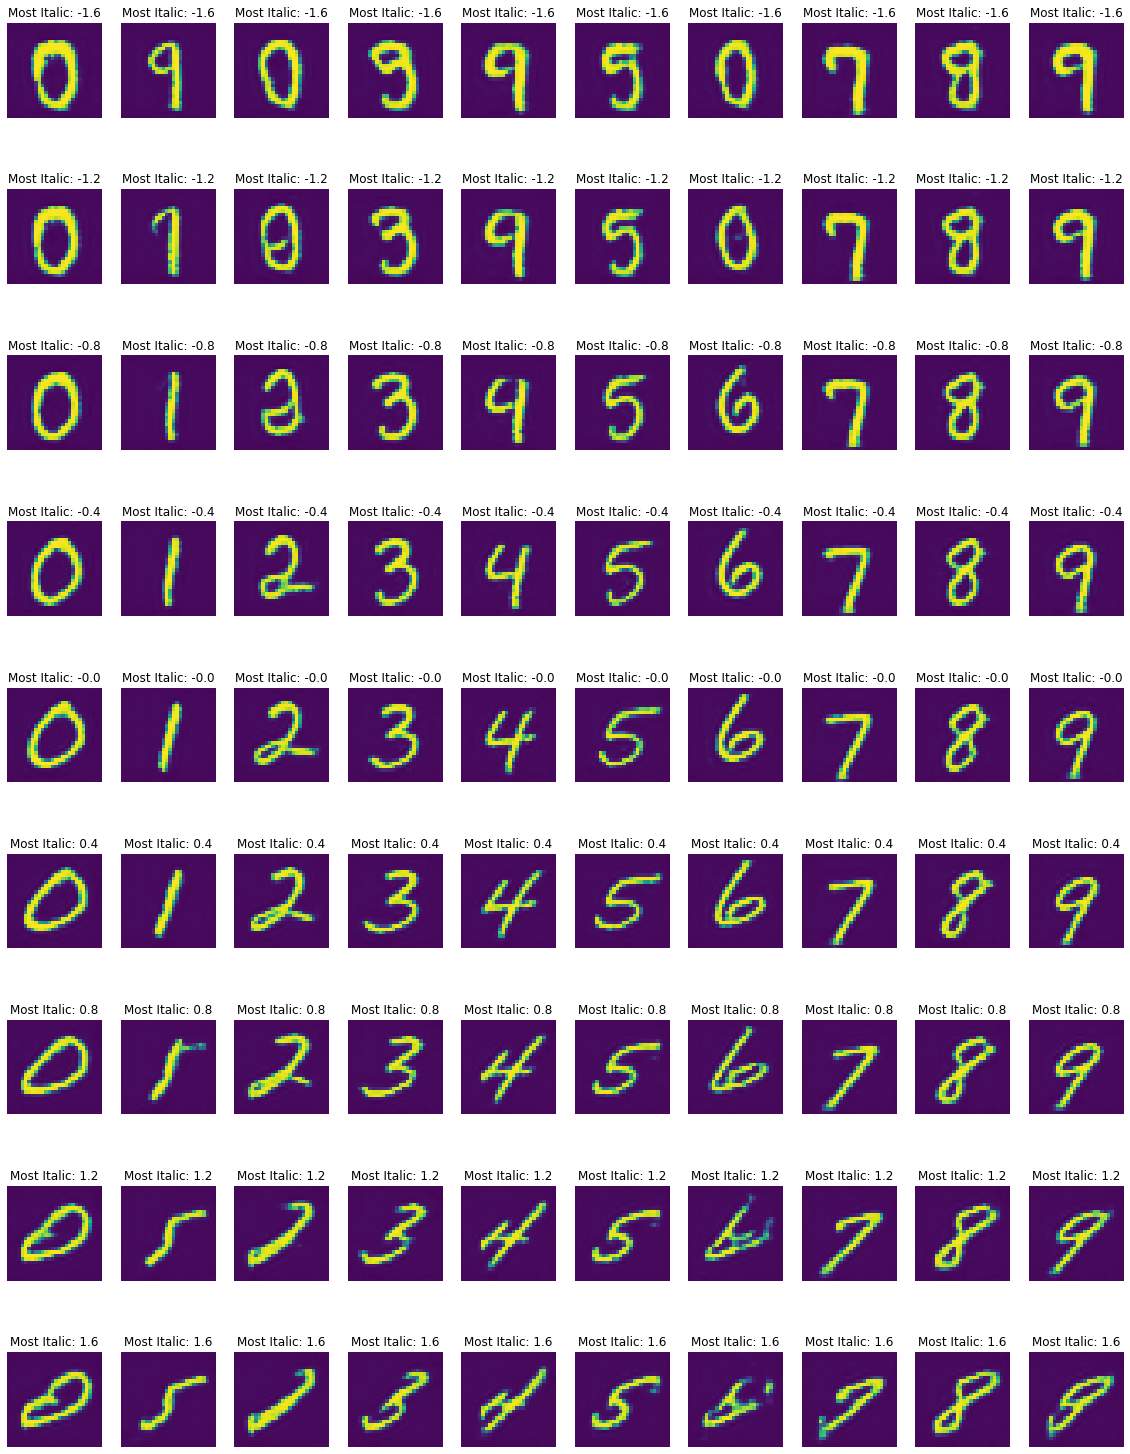

### Curviest numbers progression

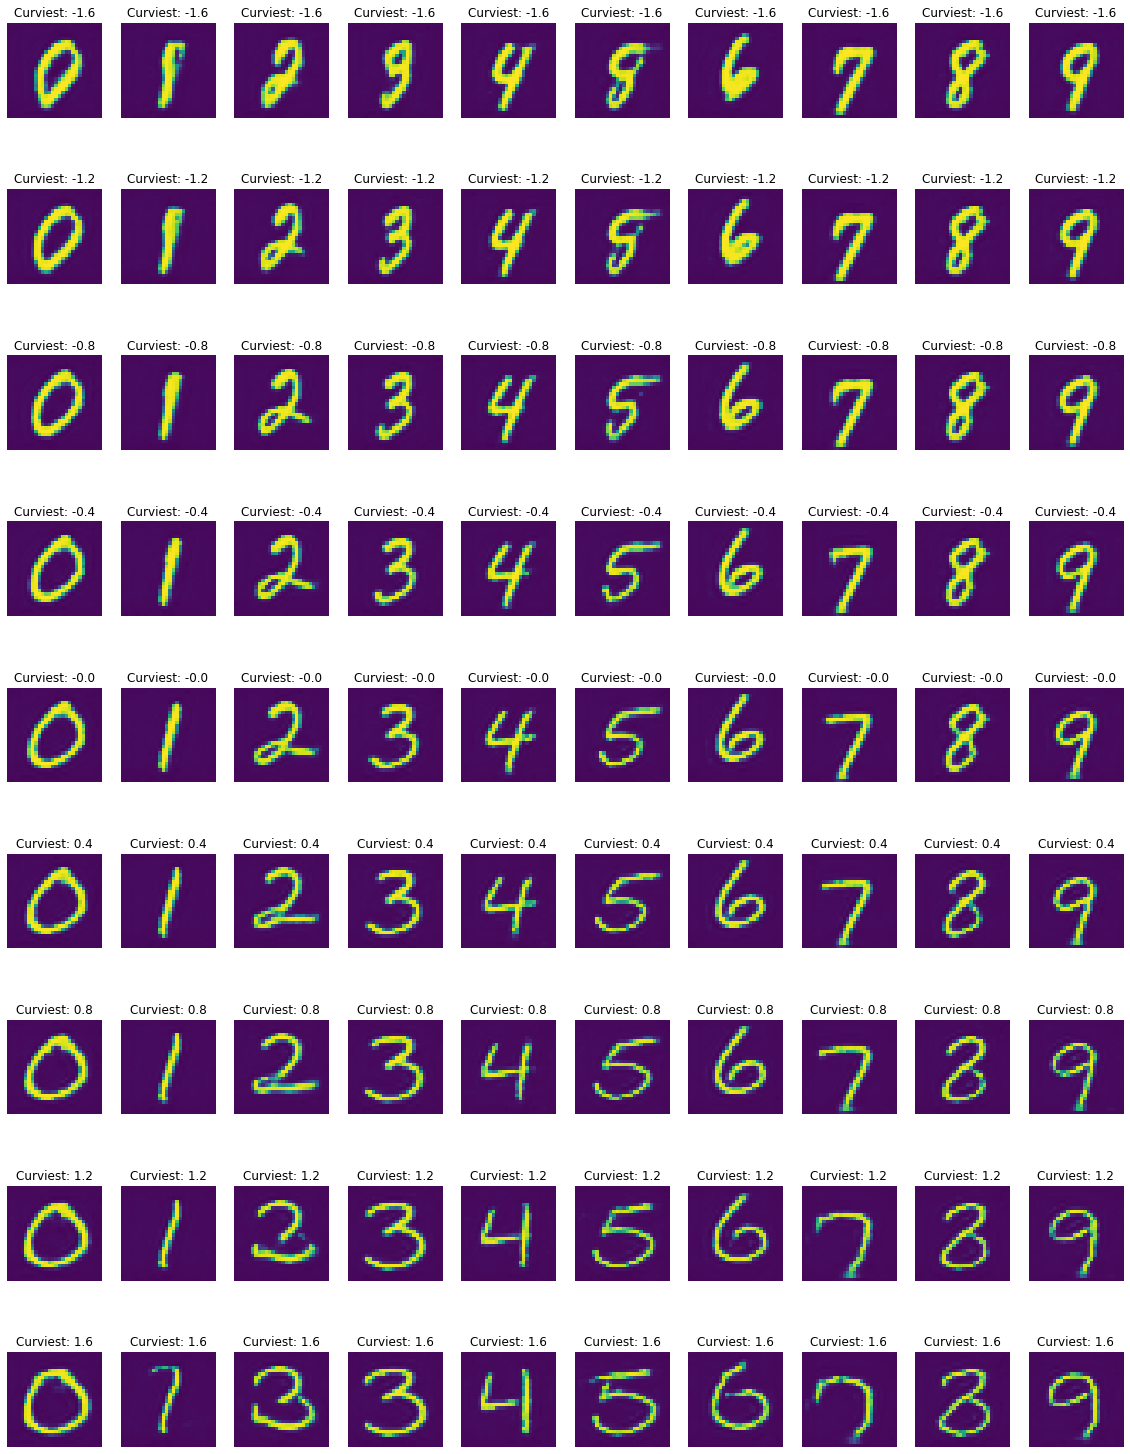

### Most Edgy numbers progression

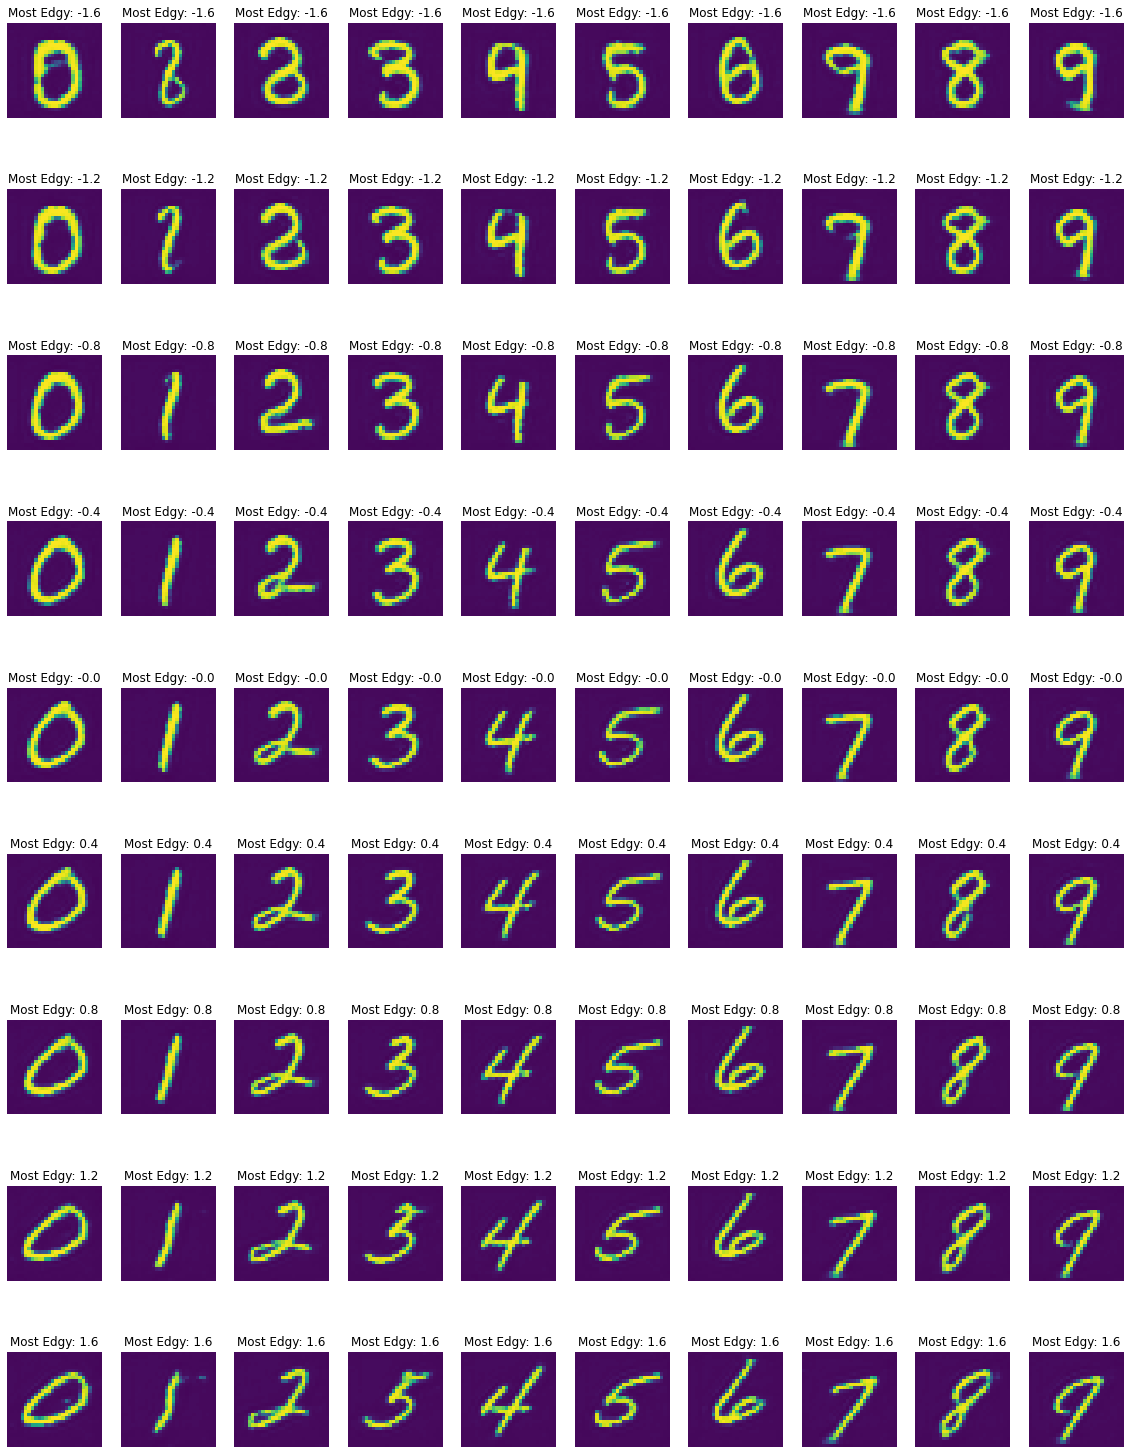

### Thinnest numbers progression

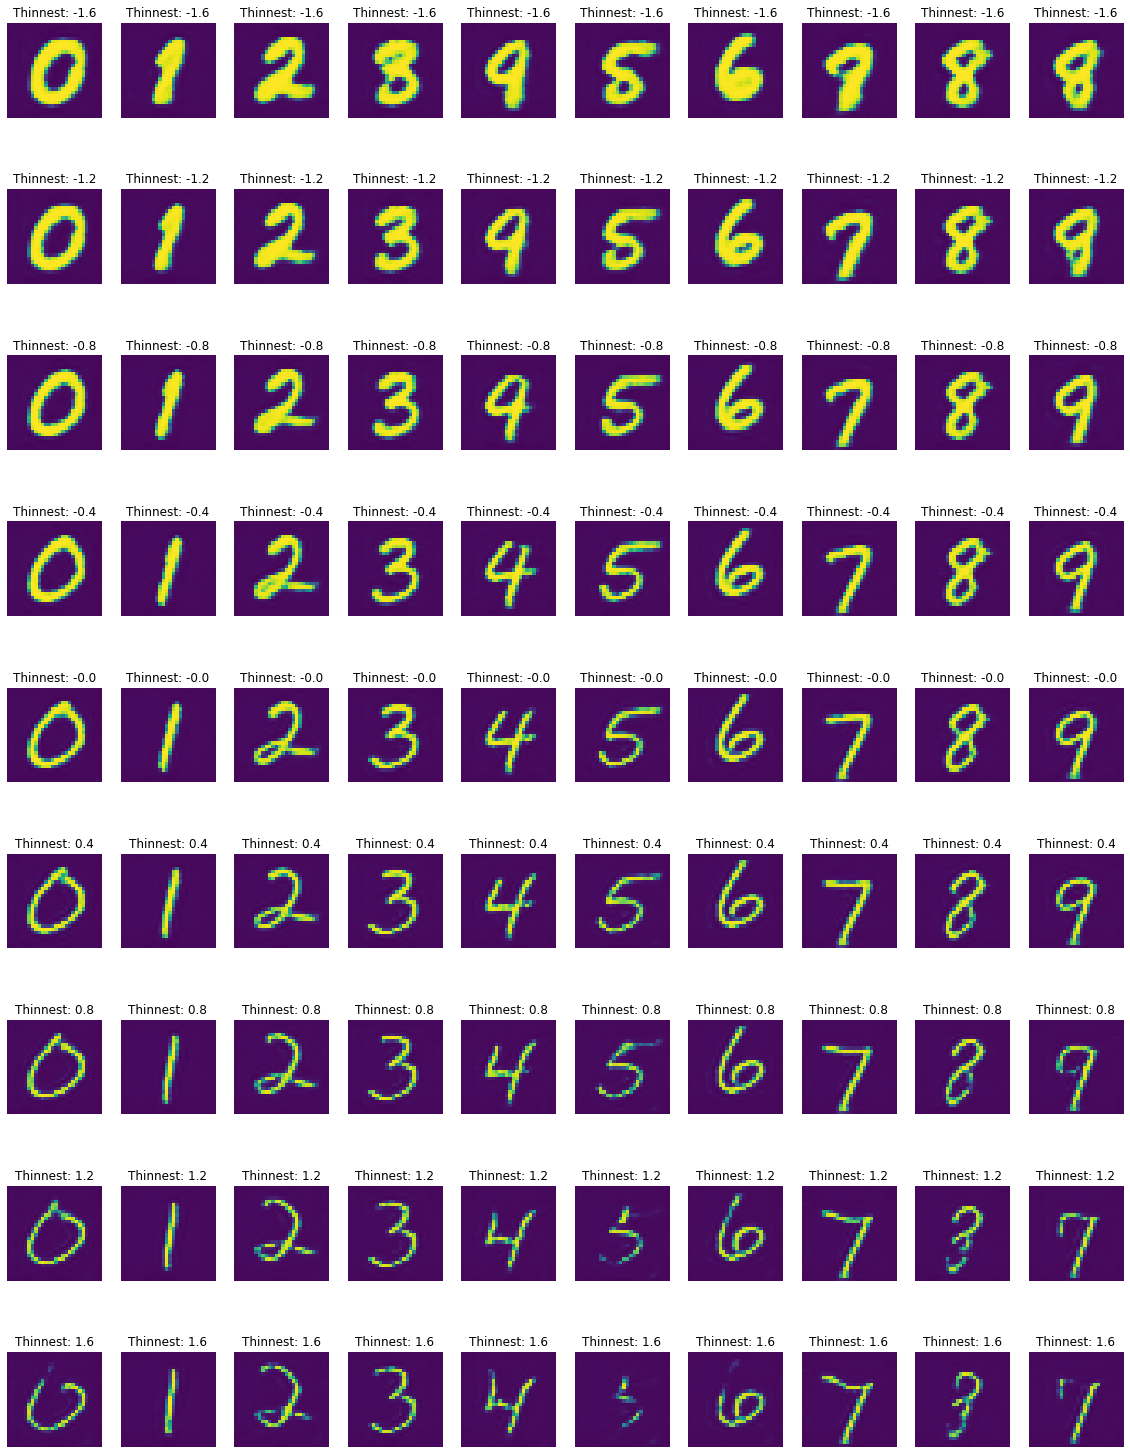

In [15]:
def moveAlong(originalEncodings, encodingToAdd, steps, intensity, title, label, compensate):

    origCount = len(originalEncodings)

    intensityStep = 2*intensity / float(steps)
    multiplier = np.arange(-intensity, intensity+intensityStep, intensityStep).reshape((-1,1)) #(steps+1, 1)

    encodingToAdd = encodingToAdd.reshape((1, -1)) #(1, encSize)
    encodingToAdd = encodingToAdd * multiplier # (steps+1, encSize)

    changedEncodings = originalEncodings.reshape((1, origCount, -1)) #(1, origCount, encSize)
    if compensate == True:
        changedEncodings = changedEncodings * (1-multiplier).reshape((-1,1,1)) #(steps+1, origCount, encSize)

    changedEncodings = changedEncodings + encodingToAdd.reshape((steps+1, 1, -1)) # (steps+1, origCount, encSize)
    images = decoder.predict(changedEncodings.reshape((-1, encSize))).reshape((-1, origCount, 28, 28))
    labels = np.concatenate([np.round(multiplier, 2)]*origCount, axis=-1)
    labels = np.char.add(label + ": ", labels.astype(str))

    display(Markdown("### "+ title))
    plotArray(images, labels)
    print("\n\n\n\n\n\n")

#allNames = traitNames + mostTraitNames + midTraitNames
allNames = traitNames + mostTraitNames
titles = [text + " numbers progression" for text in allNames]
# for traitEnc, title, label in zip(traits+mostTraits+midTraits, titles, allNames):
for traitEnc, title, label in zip(traits+mostTraits, titles, allNames):
    moveAlong(numberEncodings, traitEnc, 8, 1.6, title, label, compensate=False)

## Selecting the ideal fractions of the trait encodings

From the results above, we can see that adding a certain amount of the traits bring the expected results, but adding too much can change numbers into other numbers or unrecognizable shapes. 

Here we will select the ideal amount of each trait and create the ideal trait encodings.

- **Ideal thick encoding:** [(1.6 x thick encoding) + (1.6 x thickest)]/2  
- **Ideal thin encoding:** 1.2 x thin encoding    
- **Ideal upright encoding:** -0.5 x italic encoding   
- **Ideal italic encoding:** [(0.7 x italic encoding) + (0.5 x most italic)]/2  
- **Ideal narrow encoding:** -1.0 x curvy encoding   
- **Ideal wide curvy encoding:** 1.1 x curviest encoding   
- **Ideal non edgy encoding:** -1.0 x most edgy encoding
- **Ideal edgy encoding:** 1.0 x most edgy encoding

Some of these encodings have overlapping traits.   



### Mean numbers + Ideal encodings

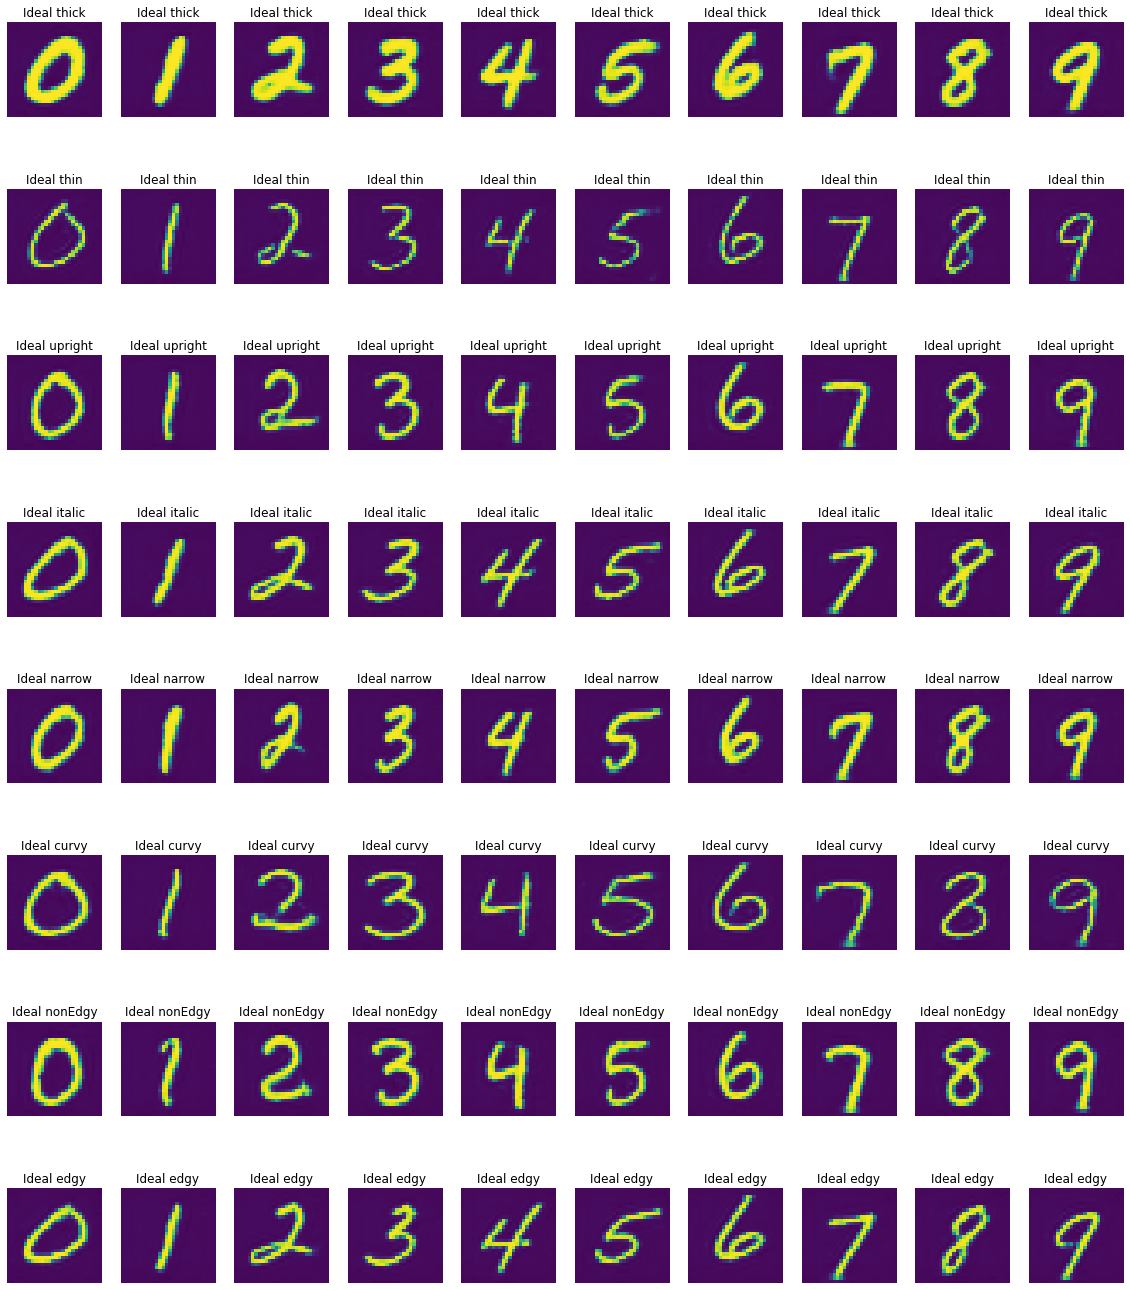

In [16]:
idealThick = (0.8 * thickEnc) + (0.8 * thickestEnc)
idealThin = 1.2 * thinEnc
idealUpright = -0.5 * italicEnc
idealItalic = (0.35*italicEnc) + (0.25*mostItalicEnc)
idealNarrow = -1.0 * curvyEnc
idealCurvy = 1.1 * mostCurvyEnc
idealNonEdgy = -1.0 * mostEdgyEnc
idealEdgy = 1.0 * mostEdgyEnc

idealTraitNames = ["Ideal " + text for text in ["thick", "thin", "upright", "italic", "narrow", "curvy", "nonEdgy", "edgy"]]
idealEncodings = [idealThick, idealThin, idealUpright, idealItalic, idealNarrow, idealCurvy, idealNonEdgy, idealEdgy]

def plotWithEncodings(names, encodings):
    images = []
    labels = []
    for trait, name in zip(encodings, names):
        traitImages = []
        traitLabels = [name] * 10
        for i in range(10):
            enc = numberEncodings[i] + trait
            image = decoder.predict(enc.reshape((1,-1)))[0]
            traitImages.append(image)
        images.append(traitImages)
        labels.append(traitLabels)
    plotArray(np.array(images).squeeze(axis=-1), np.array(labels))

display(Markdown("### Mean numbers + Ideal encodings"))
plotWithEncodings(idealTraitNames, idealEncodings)

# Mixing traits

Let's see if we can mix the traits, like creating bold italic numbers, or thin upright numbers, by simply mixing the encodings above.

We will test two approaches:
- simply adding the two encodings together (exaggerated results, not good)    
- adding a fraction of the two encodings (mild results, better)    

As done before, it's possible here to find the ideal fraction of each encoding for the best results. We found a satisfactory fraction by dividing the sum of the encodings by 1.5, but better results could be found by experimentation.   

### Visualizing mixed traits (full addition - exaggerated results - bad)

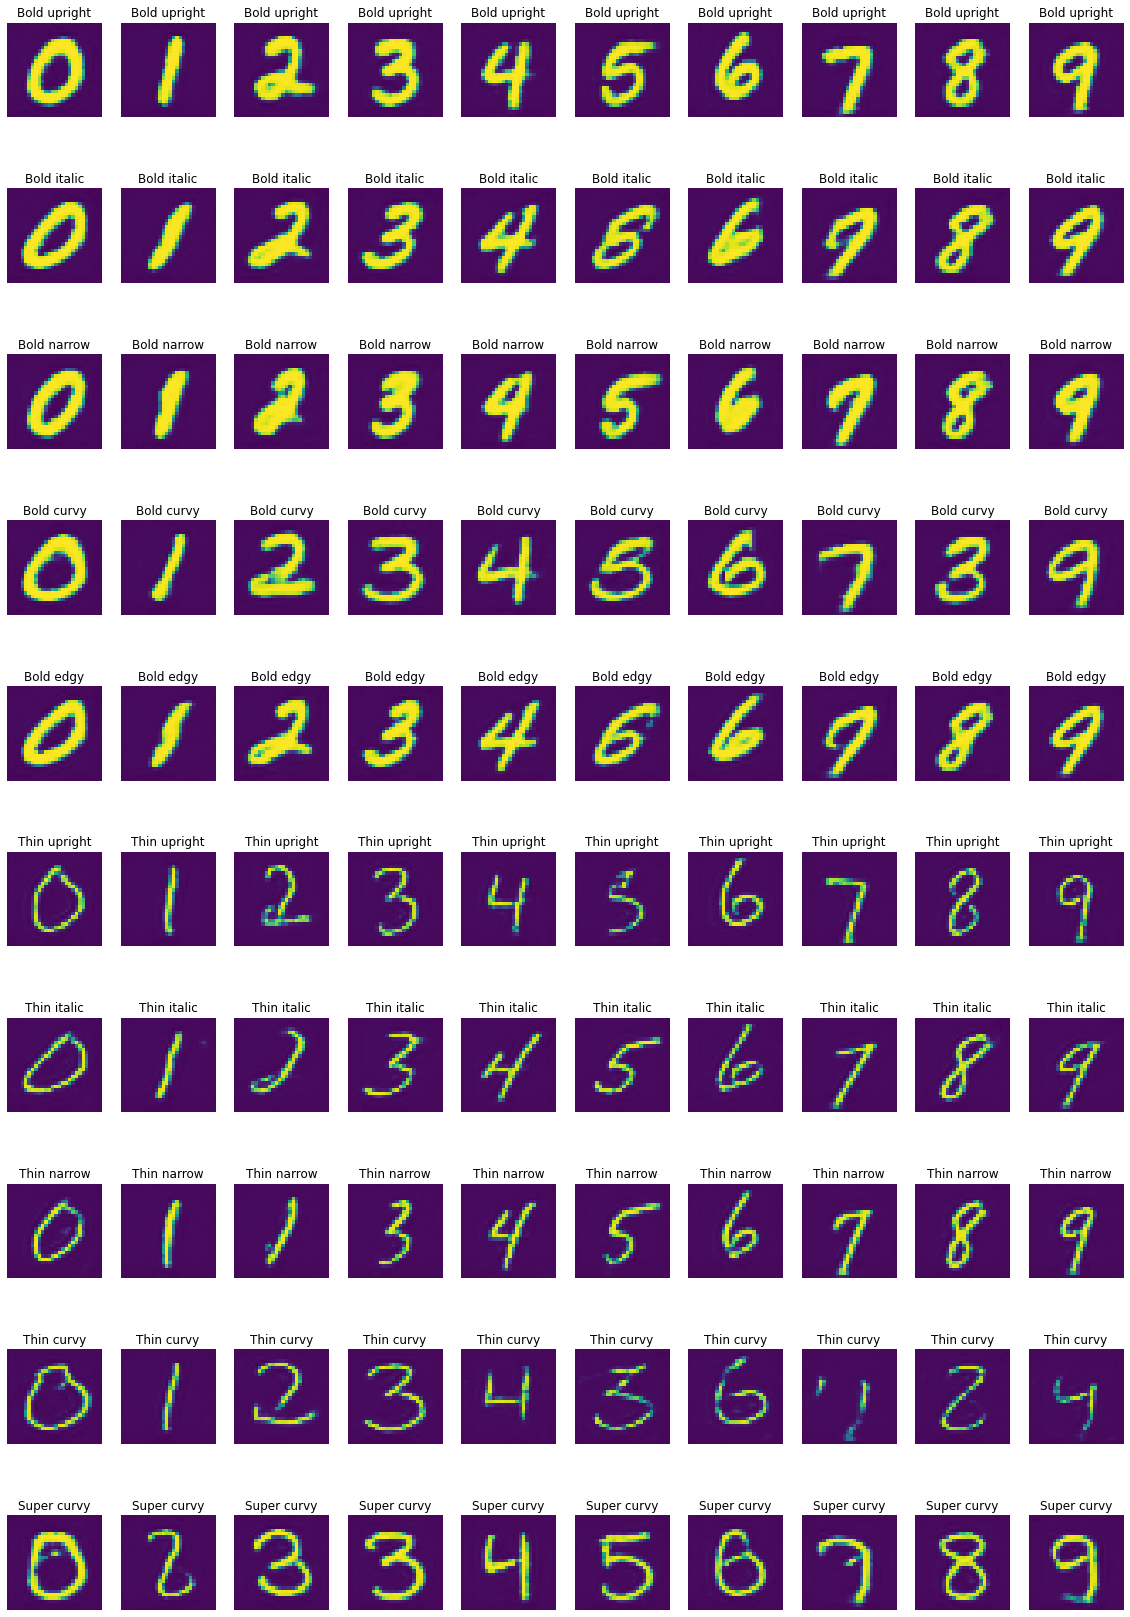

### Visualizing mixed traits (fraction - mild results - good)

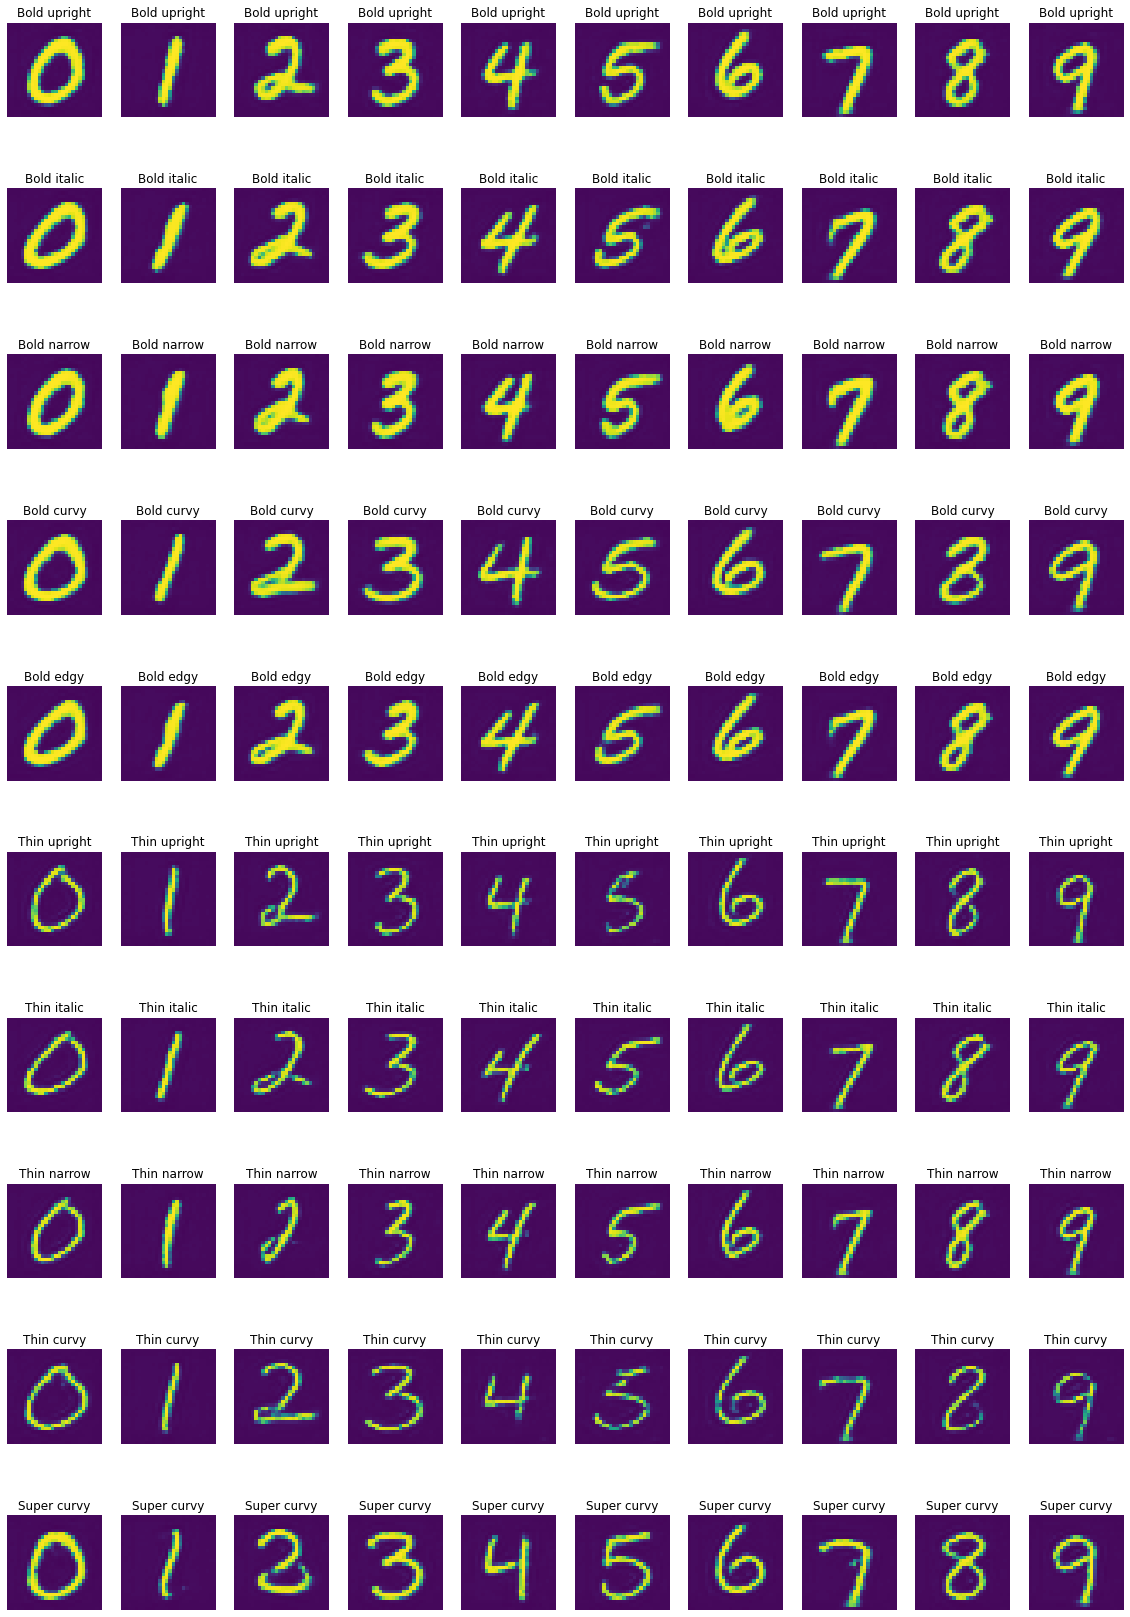

In [17]:
mixedTraitNames = ["Bold upright", 
                   "Bold italic", 
                   "Bold narrow",
                   "Bold curvy",
                   "Bold edgy",
                   "Thin upright", 
                   "Thin italic",
                   "Thin narrow",
                   "Thin curvy", 
                   "Super curvy"]
mixedEncodings = [idealThick + idealUpright, 
                  idealThick + idealItalic, 
                  idealThick + idealNarrow,
                  idealThick + idealCurvy,
                  idealThick + idealEdgy,
                  idealThin  + idealUpright, 
                  idealThin  + idealItalic,
                  idealThin  + idealNarrow,
                  idealThin  + idealCurvy,
                  idealCurvy + idealNonEdgy
                  ]
fractionMixedEncodings = [ enc / 1.5 for enc in mixedEncodings]

display(Markdown("### Visualizing mixed traits (full addition - exaggerated results - bad)"))
plotWithEncodings(mixedTraitNames, mixedEncodings)

print("\n\n")
display(Markdown("### Visualizing mixed traits (fraction - mild results - good)"))
plotWithEncodings(mixedTraitNames, fractionMixedEncodings)

# Analysing trait encodings

In this section, we will take a look at some aspects of the trait encodings, only out of curiosity.   

## Pure traits without numbers?

Here we look at the encodings we created and see how they look like if they're not added to any number encoding. 

They resemble the "mean number" we saw before, sometimes going more to 3, sometimes to 9. The expected trais are visible. 

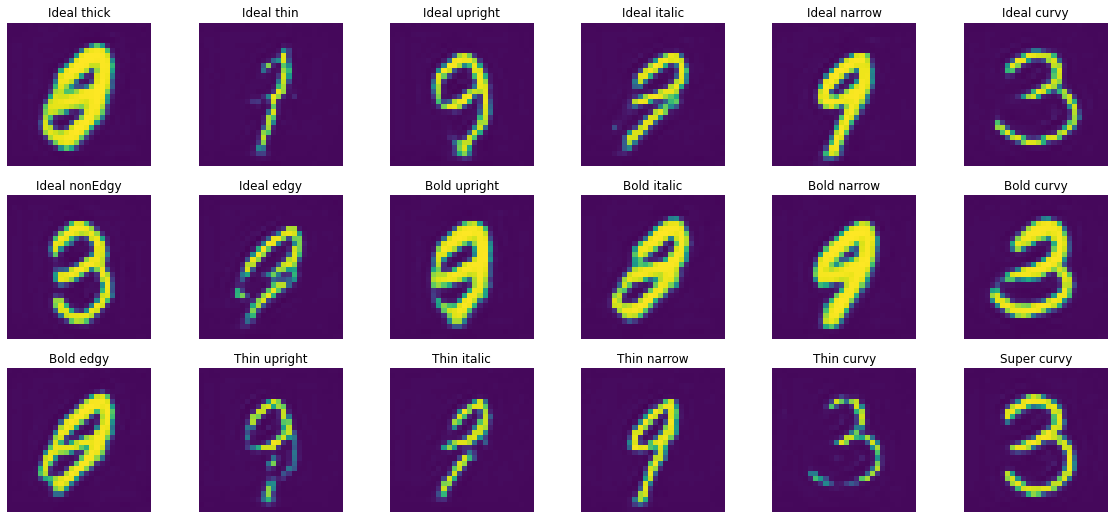

In [18]:
encs = np.stack(idealEncodings + fractionMixedEncodings, axis=0)
images = decoder.predict(encs).reshape((3, 6, 28, 28))
labels = np.array(idealTraitNames + mixedTraitNames).reshape((3,6))

plotArray(images, labels)


## Distances between the traits and numbers

Here we see if some traits are more similar to certain numbers than others.  
We did not interpret these results deeply, but a significant part of them is a reflection of the distances between each number and the mean. 

We notice that the trait encodings are closer to the mean and median than to any number, which is expected. The traits should change the shapes of a number without changing the number itself. One exception is the "super curvy" trait, which is closer to the number 3 than to the mean. 

Interesting things that make sense can be seen, like:

- 1 is very far from curvy traits    
- 0 is very far from narrow traits   

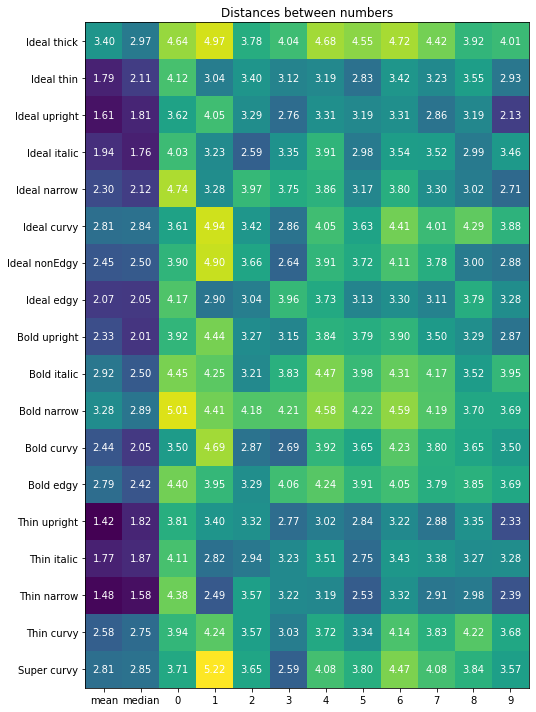

In [19]:
traitEncodings = np.array(idealEncodings + fractionMixedEncodings)
traitLabels = np.array(idealTraitNames + mixedTraitNames)

distancePlot(traitEncodings, allAndCentral, traitLabels, allAndCentralLabels)

# Number Intensity

Here we multiply the mean number encodings by a factor to see the effects. Is there such a thing as a super number, like "a seven that is very seven"?

We see an interesting change in the shapes of the numbers, and although the increased encodings might not be in the expected range of the model, they do not generate anything weird, they just create some sort of aggresive traits.   

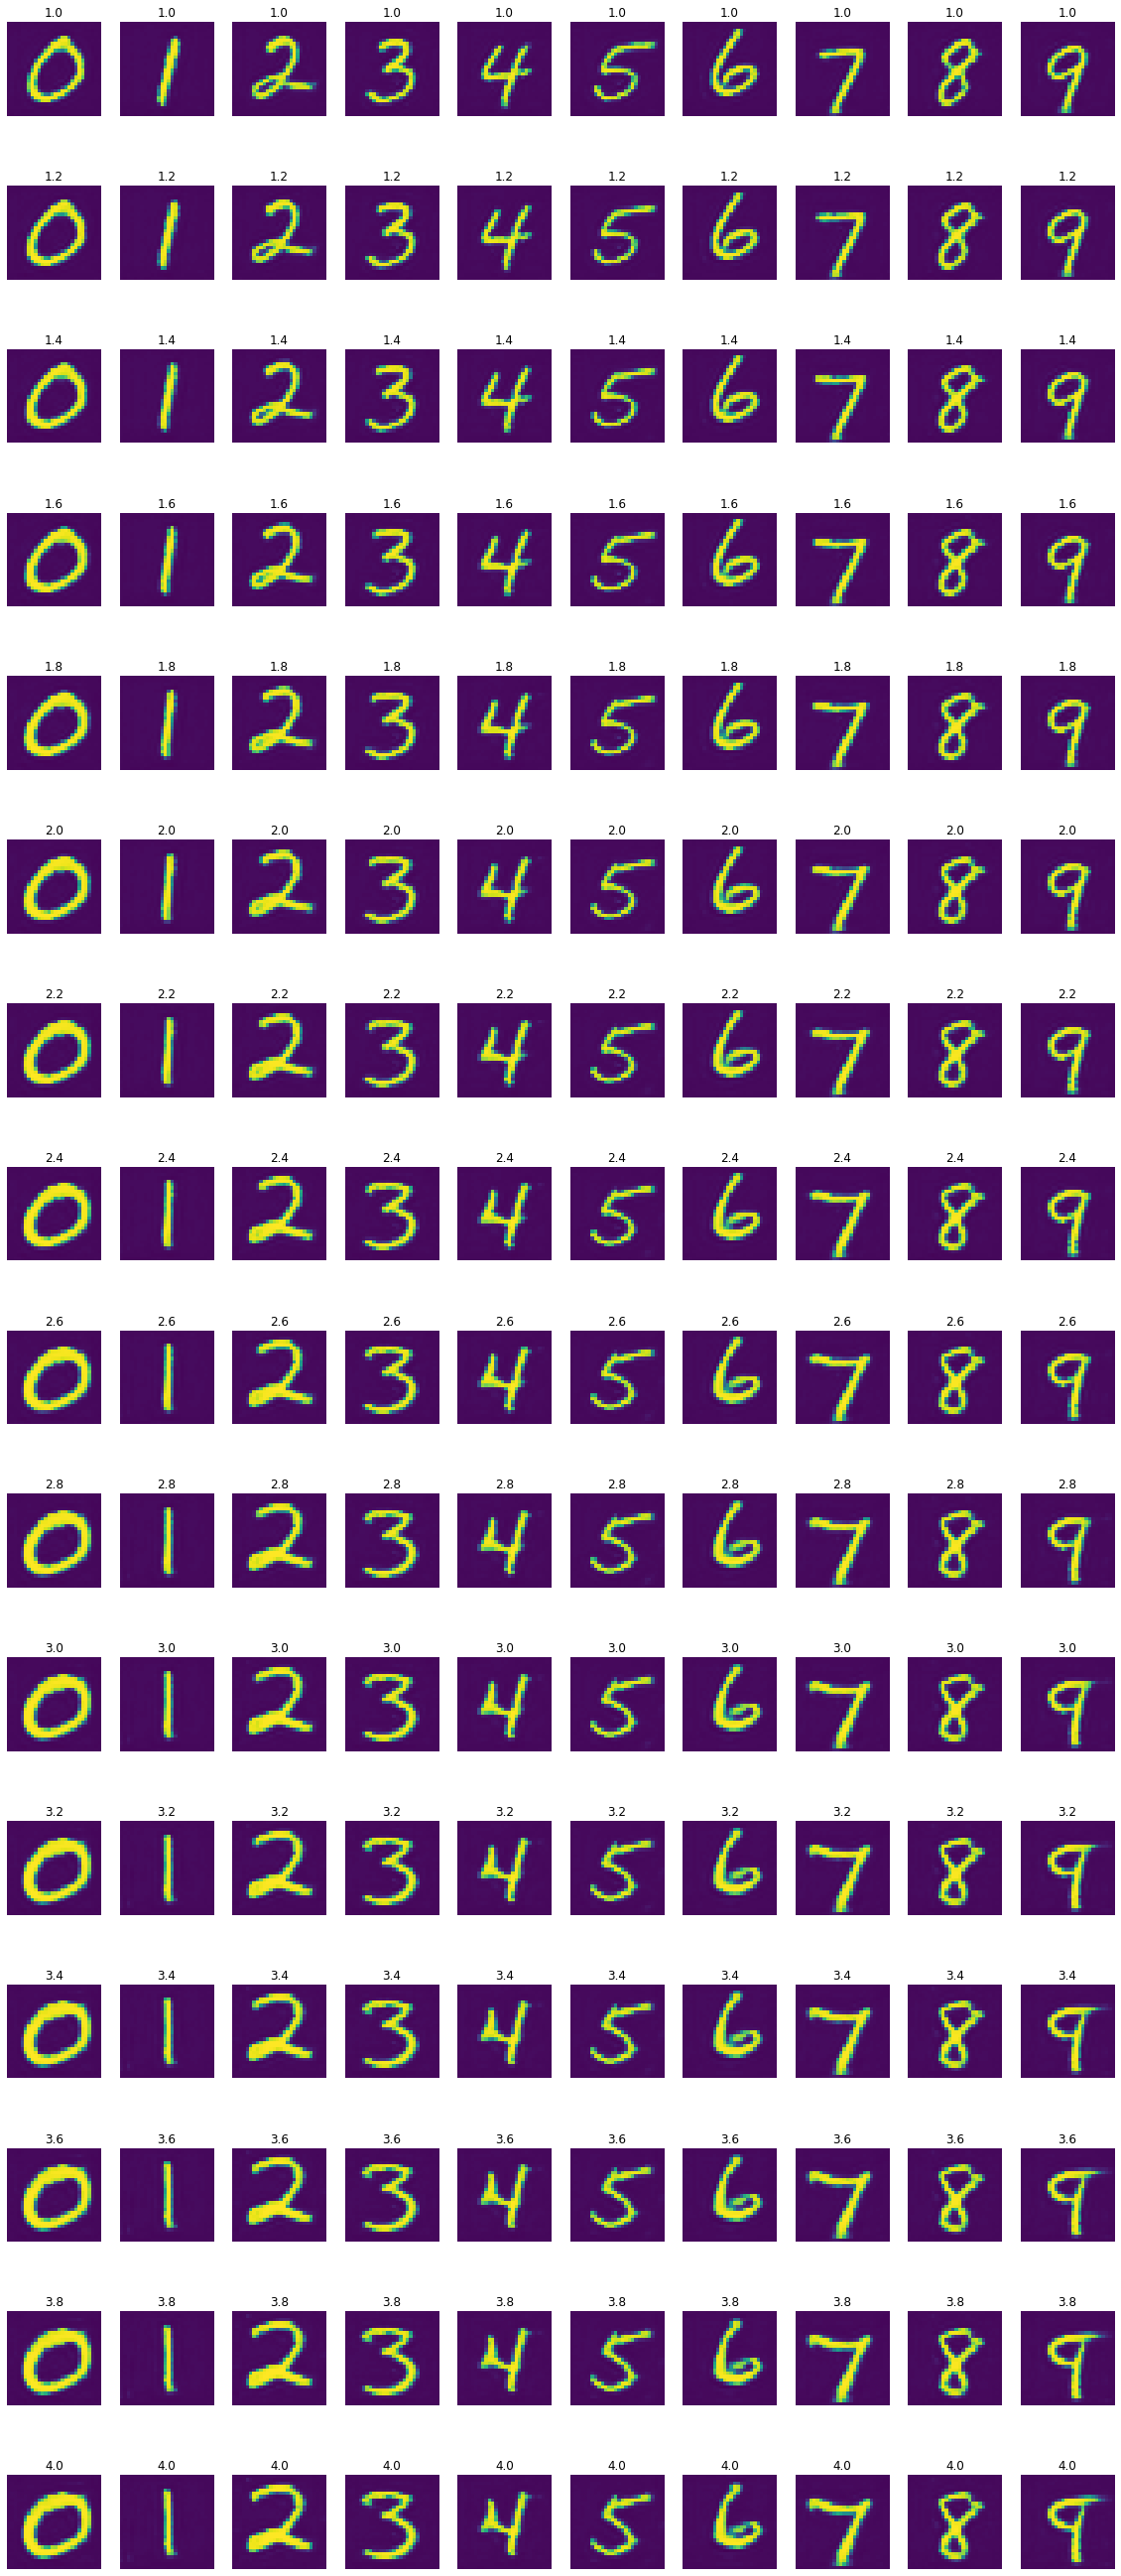

In [20]:
intensity = np.arange(1,4.1, 0.2).reshape((-1, 1, 1))
encs = numberEncodings.reshape((1, nums, encSize))
encs = (intensity*encs).reshape((-1, encSize))
images = decoder.predict(encs).reshape((-1,nums,28,28))
labels = np.round(np.concatenate([intensity]*nums, axis=1).reshape((-1,nums)), decimals=2)
plotArray(images, labels)

# Conclusions   

In this project we demonstrated that it's possible to associate Variational Autoencoders (VAE) and Generative Adversarial Networks (GAN) in order to produce high quality controlled images. 

It is possible to obtain encodings from number images and use mathematical operations with these encodings to add or remove desired traits and produce images according to our intents. 

The tests successfully show that the encodings for traits follow a logical pattern, they can be transfered from one number to another, and it's possible to transition between the traits and their opposite by simply multiplying them by a coefficient.

All the generated images in which the values of the encodings were not exaggerated kept great quality, showing that the proposed method works well.